In [1]:
import json
import pandas as pd
import numpy as np

In [2]:
d = json.load(open('/Users/stefan/Downloads/phase1-data.json'))

In [3]:
del d['Stefan, Wed Nov 14 2018 19:17:18 GMT-0800 (Pacific Standard Time)']

In [4]:
def iterate_replays(variant_d, key):
    for replay in [k for k in variant_d if k.startswith('replay')]:
        if key in variant_d[replay]:
            yield variant_d[replay][key]

In [860]:
PHYSIO_DIMS = [
    'skin_temp',
    'ibi',
    'ibis',
    'hr'
]

EMO_DIMS = [
    'happiness',
    'saddness',
    'surprise',
    'fear',
    'anger',
    'disgust',
]

In [1001]:
variant_rows = []
user_rows = []
physio_rows = []
emo_rows = []

for user in d:
    u = user.split(',')[0]

    variant_labels = []
    
    for variant in [k for k in d[user] if k.startswith('variant')]:
        ratings = d[user][variant]['ratings']
        variant_labels.append(d[user][variant]['replay-1']['game_type'])

        scores = [
            len(xs)
            for xs in iterate_replays(d[user][variant], 'x')
        ]
        replay_durations = [
            (int(times[-1]) - int(times[0])) / 1000
            for times in iterate_replays(d[user][variant], 'time')
        ]
        
        
        ver = d[user][variant]['replay-1']['game_type']
        variant_rows.append({
            'user': u,
            'ver': ver,
            
            'max_score': max(scores),
            'avg_score': sum(scores) / len(scores),
            'total_duration': sum(replay_durations),
            **ratings
        })
        
        physio_rows += [
            [{
                'user': u,
                'ver': ver,
                'replay': replay,
                
                **{d: v for d, v in zip(PHYSIO_DIMS, vals)}
            } for vals in physio_data]
            for replay, physio_data in enumerate(iterate_replays(d[user][variant], 'all_physio'))
        ]
        emo_rows += [
            [{
                'user': u,
                'ver': ver,
                'replay': replay,
                
                **{d: v for d, v in zip(EMO_DIMS, vals)}
            } for vals in emo_data]
            for replay, emo_data in enumerate(iterate_replays(d[user][variant], 'all_emotions'))
        ]
    
    user_rows.append({
        'user': u,
        'competitiveness': d[user]['subjectInfo']['competitive'],
        'skill': d[user]['subjectInfo']['skill'],
        'favorite_ver': variant_labels[d[user]['subjectInfo']['bestVariant']-1],
        'affective_ver_first': variant_labels.index('Affective') < variant_labels.index('Classical'),
    })

variant_df = pd.DataFrame(variant_rows).set_index(['user', 'ver'], drop=False)
user_df    = pd.DataFrame(user_rows).set_index('user')
physio_df  = pd.DataFrame(sum(physio_rows, []))
emo_df     = pd.DataFrame(sum(emo_rows, []))

In [1002]:
physio_df = physio_df[physio_df.skin_temp < 50]

In [1003]:
pseudonuyms = {
    name: f'P{idx}'
    for idx, name in enumerate(physio_df.groupby('user').hr.mean().sort_values(ascending=False).index)
}

physio_df['pseudonym'] = physio_df.user .map(pseudonuyms.get)
emo_df   ['pseudonym'] = emo_df   .user .map(pseudonuyms.get)
user_df  ['pseudonym'] = user_df  .index.map(pseudonuyms.get)

In [1004]:
pseudonuyms

{'jeffrey stone': 'P0',
 'Jared Zhao': 'P1',
 'Jiaoyang': 'P2',
 'Justin Ly': 'P3',
 'Yilei': 'P4',
 'Anupriya': 'P5',
 'Daniel': 'P6',
 'Minha': 'P7'}

In [1005]:
variant_df = variant_df\
    .join(physio_df.groupby(['user', 'ver']).mean()[PHYSIO_DIMS].rename(lambda c: c + '_avg', axis=1))\
    .join(emo_df   .groupby(['user', 'ver']).mean()[EMO_DIMS]   .rename(lambda c: c + '_avg', axis=1))\
    .join(physio_df.groupby(['user', 'ver']).mean()[PHYSIO_DIMS].rename(lambda c: c + '_std', axis=1))\
    .join(emo_df   .groupby(['user', 'ver']).mean()[EMO_DIMS]   .rename(lambda c: c + '_std', axis=1))

In [1006]:
user_df = user_df\
    .join(physio_df.groupby('user').mean()[PHYSIO_DIMS].rename(lambda c: c + '_avg', axis=1))\
    .join(emo_df   .groupby('user').mean()[EMO_DIMS]   .rename(lambda c: c + '_avg', axis=1))\
    .join(physio_df.groupby('user').mean()[PHYSIO_DIMS].rename(lambda c: c + '_std', axis=1))\
    .join(emo_df   .groupby('user').mean()[EMO_DIMS]   .rename(lambda c: c + '_std', axis=1))

In [1007]:
variant_df

avg_score  difficulty  enjoyment  max_score  \
user          ver                                                      
Anupriya      Easy       15.333333           3          5         17   
              Hard        7.666667           5          5         11   
              Affective   7.500000           4          5         10   
              Classical   6.600000           5          4          8   
Daniel        Easy       23.333333           3          4         25   
              Hard        9.666667           5          4         10   
              Classical  18.800000           4          4         24   
              Affective  14.333333           4          4         16   
Jared Zhao    Easy       25.500000           3          4         30   
              Hard        8.000000           5          5         10   
              Classical  11.100000           3          5         21   
              Affective  13.142857           4          4         18   
Jiaoyang      Easy       22.000000           3          4         23   
              Hard       10.000000           5          4         10   
              Classical  12.250000           4          3         16   
              Affective   7.500000           4          3         11   
Justin Ly     Easy       38.000000           2          4         38   
              Hard        6.000000           5          3          7   
              Classical  15.200000           4          4         20   
              Affective  11.666667           4          3         15   
Minha         Easy        5.500000           1          3          8   
              Hard        4.000000           3          3          4   
              Classical   7.500000           3          3         11   
              Affective   5.571429           3          3          8   
Serena Zhu    Easy       26.500000           3          4         32   
              Hard        8.500000           5          2          9   
              Classical  14.250000           4          3         17   
              Affective  11.200000           4          4         15   
Timothy Wang  Easy       28.000000           4          2         35   
              Hard       11.500000           5          3         12   
              Affective  12.000000           4          3         17   
              Classical  11.333333           4          2         23   
Yilei         Easy       26.000000           2          2         29   
              Hard        4.500000           4          3          5   
              Classical  10.200000           3          3         17   
              Affective  10.333333           3          2         14   
jeffrey stone Easy       23.500000           3          4         25   
              Hard       15.000000           4          4         18   
              Affective  12.333333           4          4         18   
              Classical  19.333333           4          4         23   

                         total_duration           user  valence        ver  \
user          ver                                                            
Anupriya      Easy               57.231       Anupriya        4       Easy   
              Hard               30.487       Anupriya        5       Hard   
              Affective          42.732       Anupriya        5  Affective   
              Classical          51.013       Anupriya        4  Classical   
Daniel        Easy               86.746         Daniel        4       Easy   
              Hard               32.377         Daniel        3       Hard   
              Classical         133.398         Daniel        4  Classical   
              Affective          53.780         Daniel        3  Affective   
Jared Zhao    Easy               63.591     Jared Zhao        4       Easy   
              Hard               16.074     Jared Zhao        3       Hard   
              Classical         160.301     Jared Zhao        4 

---

In [1008]:
for user, user_rows in variant_df.groupby('user'):
    highest = user_rows.loc[user_rows.max_score.idxmax()]
    user_df.loc[user, 'highest_score_ver'] = highest.ver
    user_df.loc[user, 'highest_score'] = highest.max_score  # of all replays
    
    user_df.loc[user, 'physio_ver_duration'] = user_rows[user_rows.ver == 'Affective'].total_duration.iloc[0]
    user_df.loc[user, 'classic_ver_duration'] = user_rows[user_rows.ver == 'Classical'].total_duration.iloc[0]
    
    user_df.loc[user, 'physio_ver_enjoyment'] = user_rows[user_rows.ver == 'Affective'].enjoyment.iloc[0]
    user_df.loc[user, 'classic_ver_enjoyment'] = user_rows[user_rows.ver == 'Classical'].enjoyment.iloc[0]
    
    user_max_enjoyment = user_rows.enjoyment.max()
    rated_max_enjoyment = user_rows[user_rows.enjoyment == user_max_enjoyment].ver.tolist()
    
    user_df.loc[user, 'max_enjoyment'] = user_max_enjoyment
    user_df.loc[user, 'avg_enjoyment'] = user_rows.enjoyment.mean()
    user_df.loc[user, 'vers_rated_max'] = ', '.join(rated_max_enjoyment)

In [1019]:
user_df['valence_avg'] = variant_df.groupby('user').valence.mean()

In [1009]:
user_df

affective_ver_first  competitiveness favorite_ver  skill  \
user                                                                      
Anupriya                      True                3    Affective      1   
Daniel                       False                4    Classical      4   
Jared Zhao                   False                5         Easy      5   
Jiaoyang                     False                1         Easy      1   
Justin Ly                    False                3         Easy      3   
Minha                        False                2    Affective      1   
Serena Zhu                   False                2         Easy      2   
Timothy Wang                  True                3    Affective      2   
Yilei                        False                3         Easy      2   
jeffrey stone                 True                5         Easy      5   

              pseudonym  skin_temp_avg   ibi_avg  ibis_avg      hr_avg  \
user                                                                     
Anupriya             P5      34.684982  0.972660  0.139061   64.956548   
Daniel               P6      32.950957  0.814231  0.125772   53.442936   
Jared Zhao           P1      34.872260  0.597884  0.058842  104.425933   
Jiaoyang             P2      35.380469  0.769717  0.060447   78.702889   
Justin Ly            P3      32.820513  0.819511  0.045126   74.158790   
Minha                P7      33.005556  0.406268  0.076882   43.259844   
Serena Zhu         None            NaN       NaN       NaN         NaN   
Timothy Wang       None            NaN       NaN       NaN         NaN   
Yilei                P4      29.171740  0.688946  0.089409   73.222708   
jeffrey stone        P0      32.077006  0.580522  0.046504  105.581200   

               happiness_avg                ...                 disgust_std  \
user                                        ...                               
Anupriya           -0.167020                ...                   -0.045091   
Daniel              0.059302                ...                    0.231540   
Jared Zhao         -0.324852                ...                   -0.012258   
Jiaoyang            0.100076                ...                    0.084002   
Justin Ly           0.145234                ...                    0.054080   
Minha              -0.180309                ...                   -0.061318   
Serena Zhu         -0.612983                ...                   -0.101590   
Timothy Wang       -0.007273                ...                   -0.022677   
Yilei               0.038007                ...                    0.088199   
jeffrey stone       0.228567                ...                    0.007600   

               highest_score_ver  highest_score  physio_ver_duration  \
user                                                                   
Anupriya                    Easy           17.0               42.732   
Daniel                      Easy           25.0               53.780   
Jared Zhao                  Easy           30.0              121.694   
Jiaoyang                    Easy           23.0              103.286   
Justin Ly                   Easy           38.0               45.346   
Minha                  Classical           11.0               28.965   
Serena Zhu                  Easy           32.0               62.908   
Timothy Wang                Easy           35.0               43.489   
Yilei                       Easy           29.0               71.690   
jeffrey stone               Easy           25.0               98.578   

               classic_ver_duration  physio_ver_enjoyment  \
user                                                        
Anupriya                     51.013                   5.0   
Daniel                      133.398                   4.0   
Jared Zhao                  160.301                   4.0   
Jiaoyang                    192.293                   3.0   
Justin Ly                    89.305          

---

In [377]:
print(f'{user_df.affective_ver_first.mean():.0%} users played the physiologically adaptive version first')

30% users played the physiologically adaptive version first


In [378]:
print(f'{(user_df.favorite_ver == user_df.highest_score_ver).mean():.0%} users rated picked the highest scoring version as their favorite')

60% users rated picked the highest scoring version as their favorite


In [379]:
print(f'{(user_df.highest_score_ver == "Easy").mean():.0%} users got their highest score on the easiest version')

90% users got their highest score on the easiest version


In [385]:
print(f'{(user_df.favorite_ver == "Affective").mean():.0%} users picked the phisiologically-adaptive as their favorite')

30% users picked the phisiologically-adaptive as their favorite


In [381]:
print(f'{(user_df.physio_ver_duration > user_df.classic_ver_duration).mean():.0%} users played the physio-adaptive ver longer than the classically-adaptive one')

0% users played the physio-adaptive ver longer than the classically-adaptive one


In [286]:
print(f'{user_df.vers_rated_max.str.contains("Affective").mean():.0%} users assigned the physio ver their highest enjoyment rating')

'60% users assigned the physio ver their highest enjoyment rating'

In [304]:
rated_physio_higher = user_df.physio_ver_enjoyment >= user_df.classic_ver_enjoyment
played_physio_longer = user_df.physio_ver_duration >= user_df.classic_ver_duration

print(f'{rated_physio_higher.mean():.0%} users assigned the physio ver a higher enjoyment rating than classical')
print(f'{(rated_physio_higher & played_physio_longer).mean():.0%} of the users that rated physio higher also played it longer')
print(f'{(~rated_physio_higher & ~played_physio_longer).mean():.0%} of the users that rated classical higher also played it longer')

70% users assigned the physio ver a higher enjoyment rating than classical
0% of the users that rated physio higher also played it longer
30% of the users that rated classical higher also played it longer


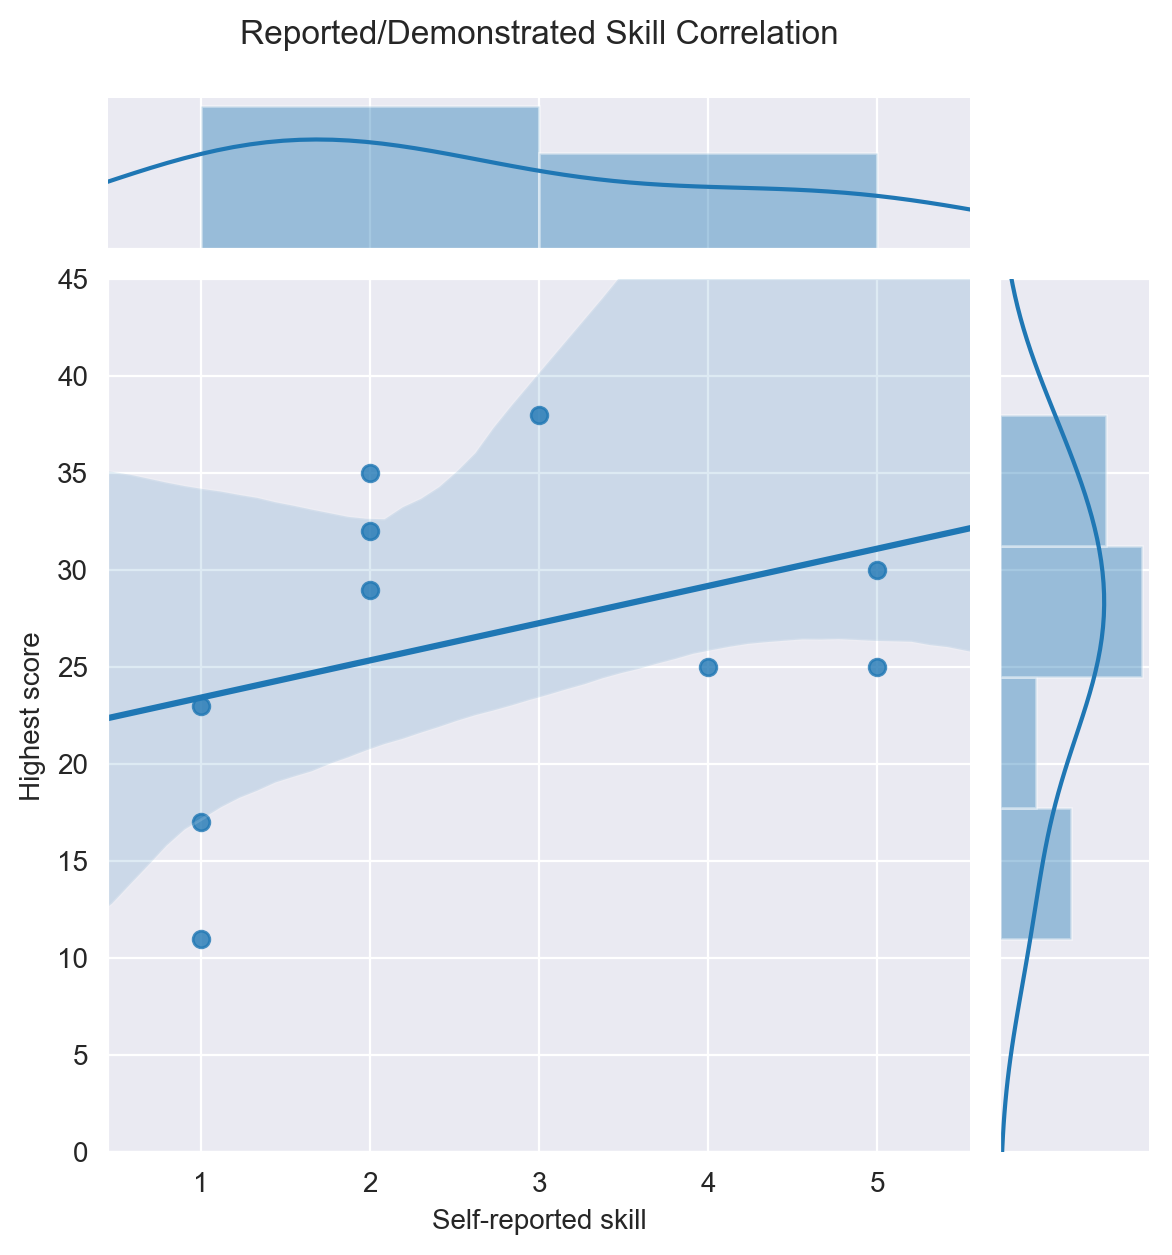

In [1021]:
sns.jointplot(user_df.skill, user_df.highest_score, kind='regg')

plt.xlim(.45, 5.55)
plt.gca().set_xticks(range(1, 6))
plt.ylim(0, 45)

plt.ylabel('Highest score')
plt.xlabel('Self-reported skill')
plt.title('Reported/Demonstrated Skill Correlation', y=1.25)

plt.show()

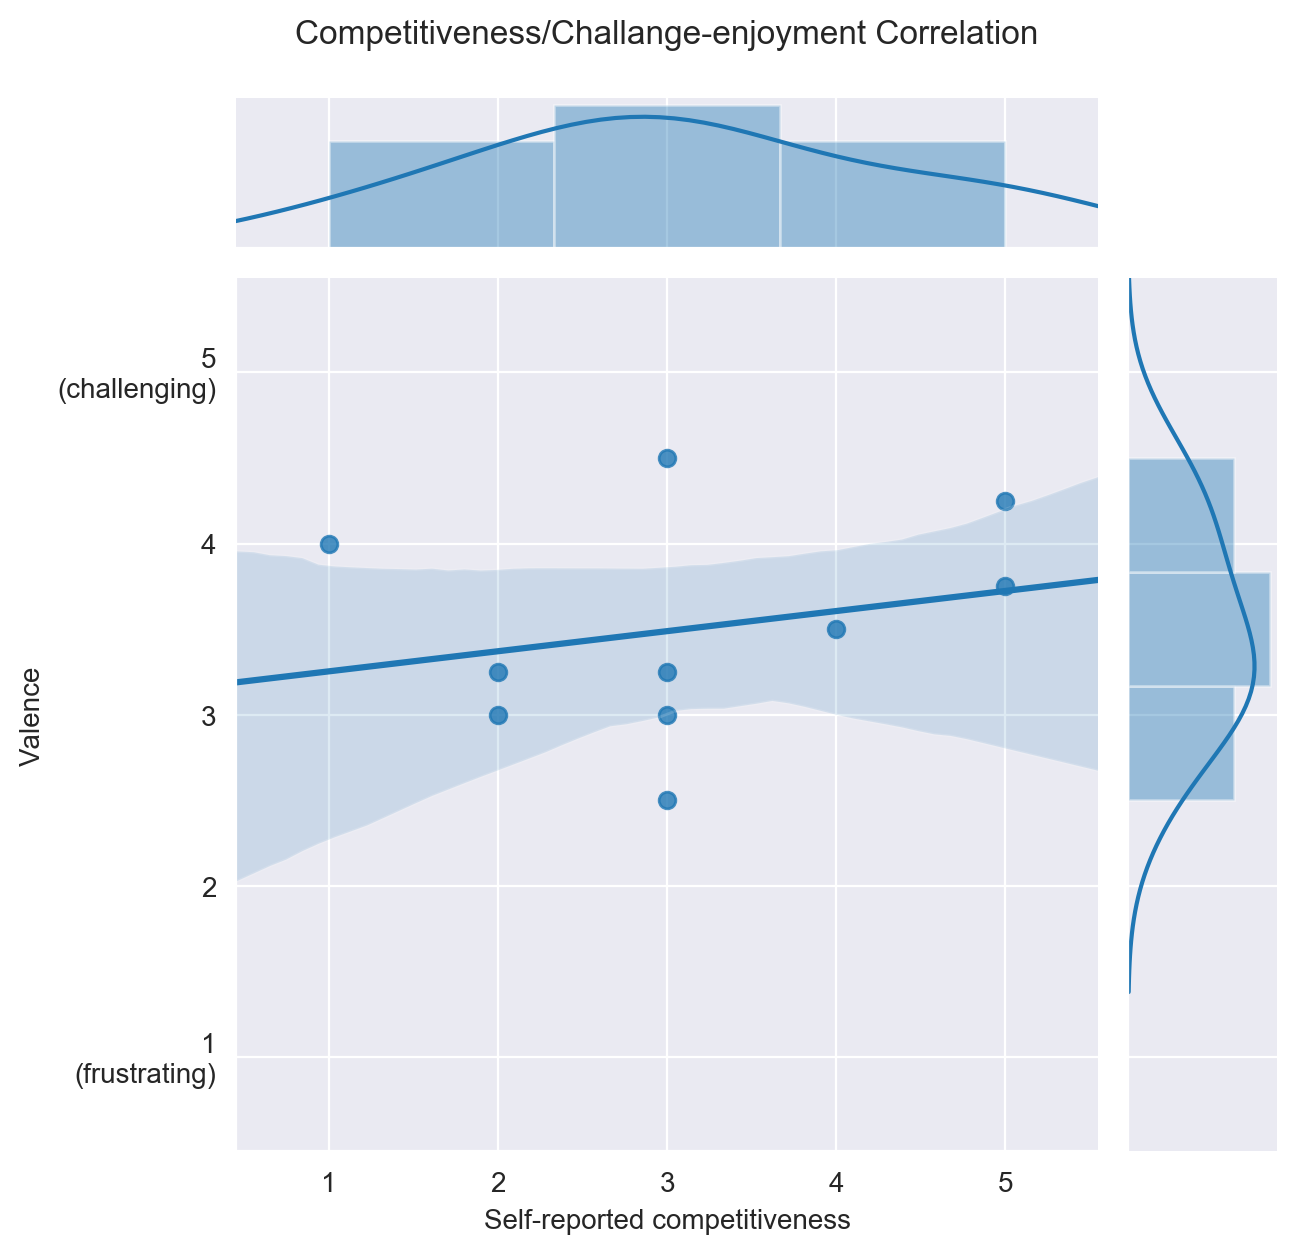

In [1030]:
sns.jointplot(user_df.competitiveness, user_df.valence_avg, kind='regg')

plt.xlim(.45, 5.55)
plt.gca().set_xticks(range(1, 6))
plt.ylim(.45, 5.55)
plt.gca().set_yticks(range(1, 6))

plt.gca().set_yticklabels([
    '1\n(frustrating)',
    '2',
    '3',
    '4',
    '5\n(challenging)'
])

plt.ylabel('Valence')
plt.xlabel('Self-reported competitiveness')
plt.title('Competitiveness/Challange-enjoyment Correlation', y=1.25)

plt.show()

---

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
import matplotlib
matplotlib.rcParams['figure.dpi'] = 200

In [305]:
pivoted = pd.pivot_table(variant_df,
    index='enjoyment',
    columns='ver',
    values='user',
    aggfunc='count',
    fill_value=0,
)
pivoted.loc[1, :] = 0

In [306]:
pivoted = pivoted[['Easy', 'Hard', 'Classical', 'Affective']]
pivoted = pivoted.loc[range(1, 6)]

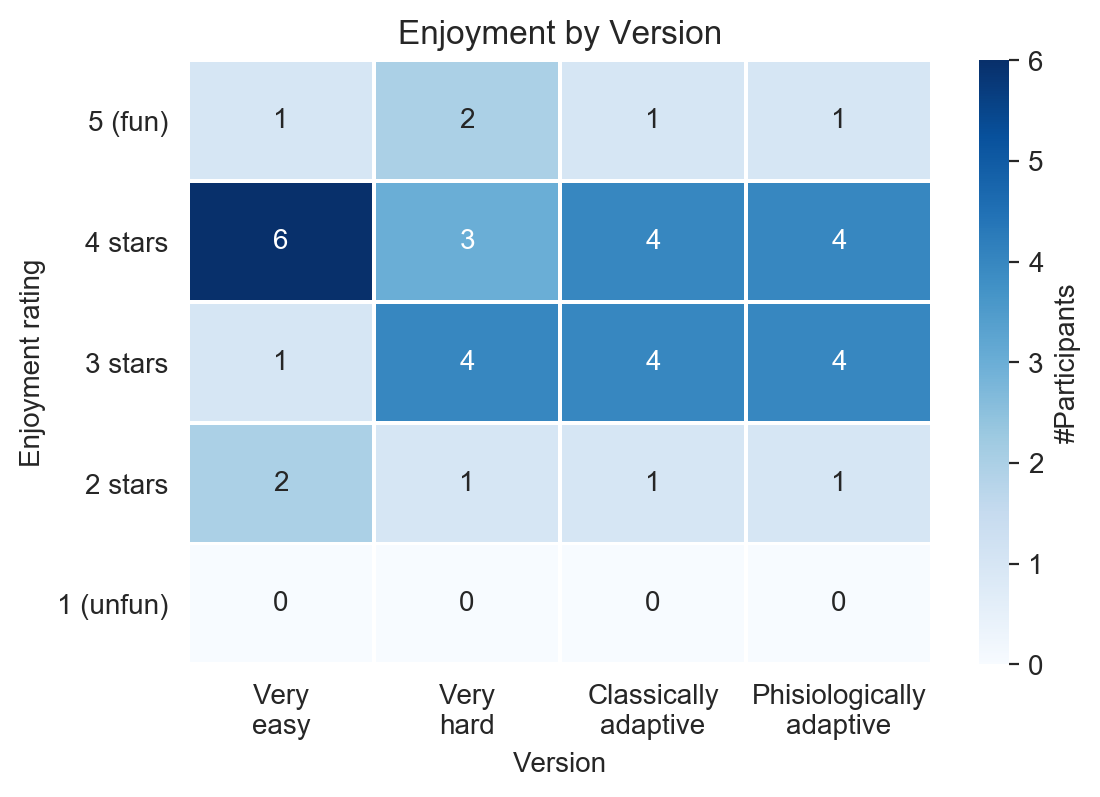

In [317]:
sns.heatmap(pivoted, 
            cmap='Blues', linewidth=1, annot=True, fmt='.0f', cbar_kws=dict(label='#Participants'))
plt.gca().invert_yaxis()

plt.gca().set_yticks([i - .5 for i in range(1, 6)])
plt.gca().set_yticklabels([
    '1 (unfun)',
    '2 stars',
    '3 stars',
    '4 stars',
    '5 (fun)'
], rotation=0)
plt.ylabel('Enjoyment rating')

plt.gca().set_xticklabels([
    'Very\neasy',
    'Very\nhard',
    'Classically\nadaptive',
    'Phisiologically\nadaptive'
])
plt.xlabel('Version')

plt.title('Enjoyment by Version')

plt.show()

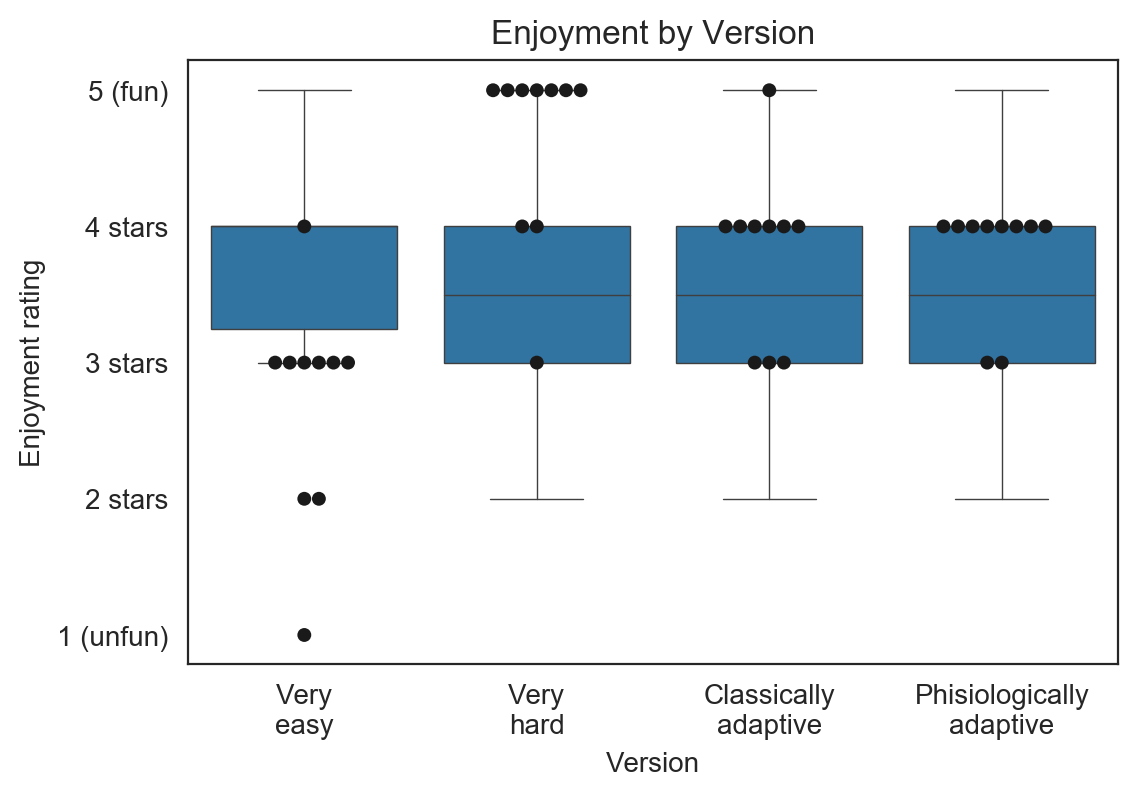

In [316]:
sns.boxplot(x='ver', y='enjoyment', data=variant_df, 
            color='C0', linewidth=.5, fliersize=0,
            order=['Easy', 'Hard', 'Classical', 'Affective'])

sns.swarmplot(x='ver', y='difficulty', data=variant_df, 
            color='.1', edgecolor='black',
            order=['Easy', 'Hard', 'Classical', 'Affective'])

plt.gca().set_yticks(range(1, 6))
plt.gca().set_yticklabels([
    '1 (unfun)',
    '2 stars',
    '3 stars',
    '4 stars',
    '5 (fun)'
])
plt.ylabel('Enjoyment rating')

plt.gca().set_xticklabels([
    'Very\neasy',
    'Very\nhard',
    'Classically\nadaptive',
    'Phisiologically\nadaptive'
])
plt.xlabel('Version')

plt.title('Enjoyment by Version')

plt.show()

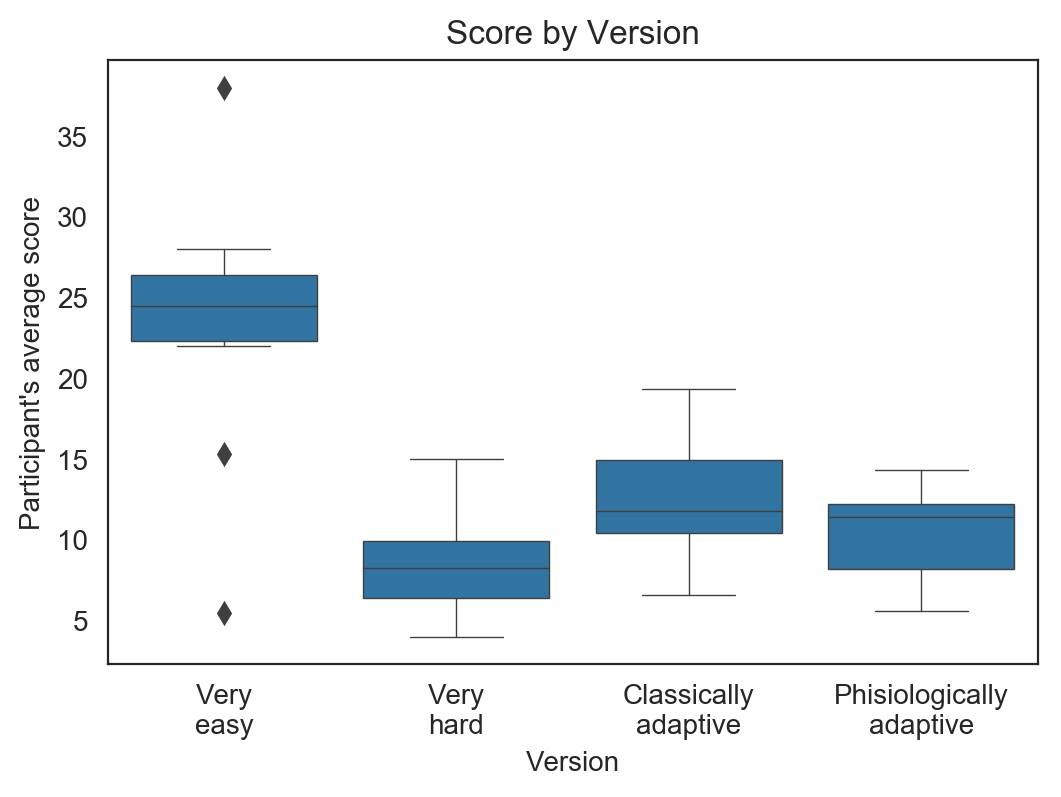

In [315]:
sns.boxplot(x='ver', y='avg_score', data=variant_df, 
            color='C0', linewidth=.5,
            order=['Easy', 'Hard', 'Classical', 'Affective'])

plt.ylabel("Participant's average score")

plt.gca().set_xticklabels([
    'Very\neasy',
    'Very\nhard',
    'Classically\nadaptive',
    'Phisiologically\nadaptive'
])
plt.xlabel('Version')

plt.title('Score by Version')
plt.show()

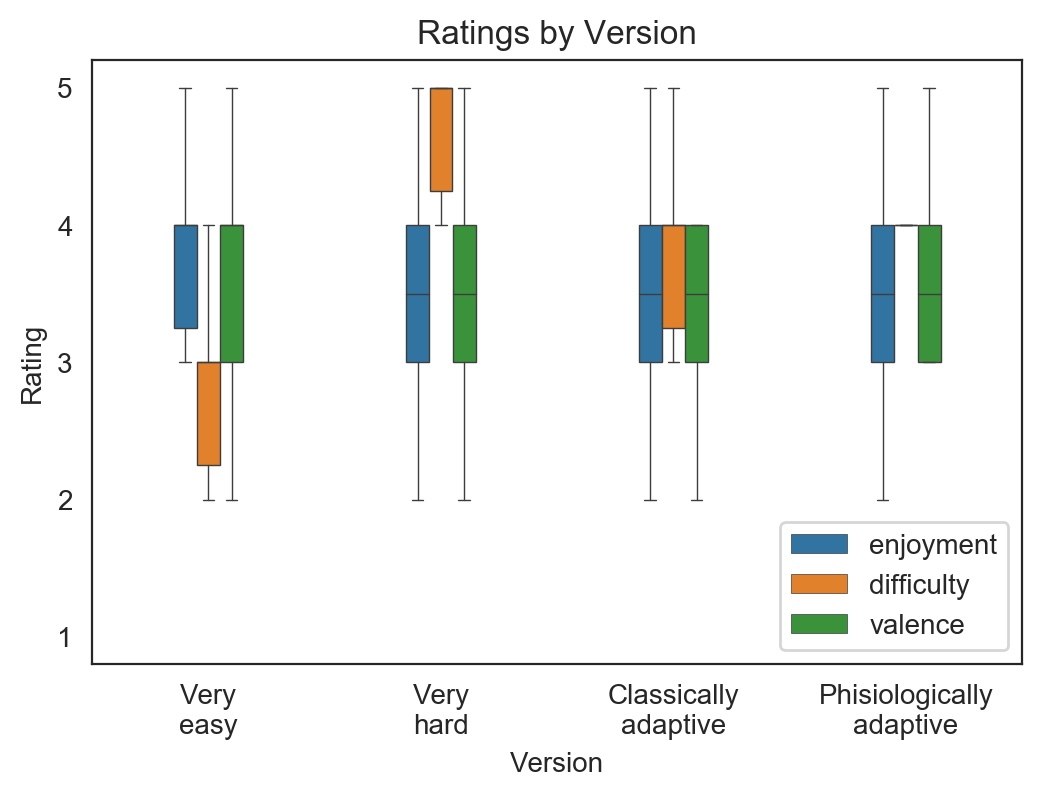

In [321]:
data = pd.melt(variant_df, id_vars=['ver'], value_vars=['enjoyment', 'difficulty', 'valence'], value_name='rating', var_name='dimension')
sns.boxplot(x='ver', y='rating', hue='dimension', data=data, 
            palette=None, linewidth=.5, fliersize=0, width=.3,
            order=['Easy', 'Hard', 'Classical', 'Affective'])
# sns.despine(offset=1, trim=True)


plt.gca().set_yticks(range(1, 6))
plt.ylabel('Rating')

plt.gca().set_xticklabels([
    'Very\neasy',
    'Very\nhard',
    'Classically\nadaptive',
    'Phisiologically\nadaptive'
])
plt.xlabel('Version')
plt.legend()

plt.title('Ratings by Version')

plt.show()

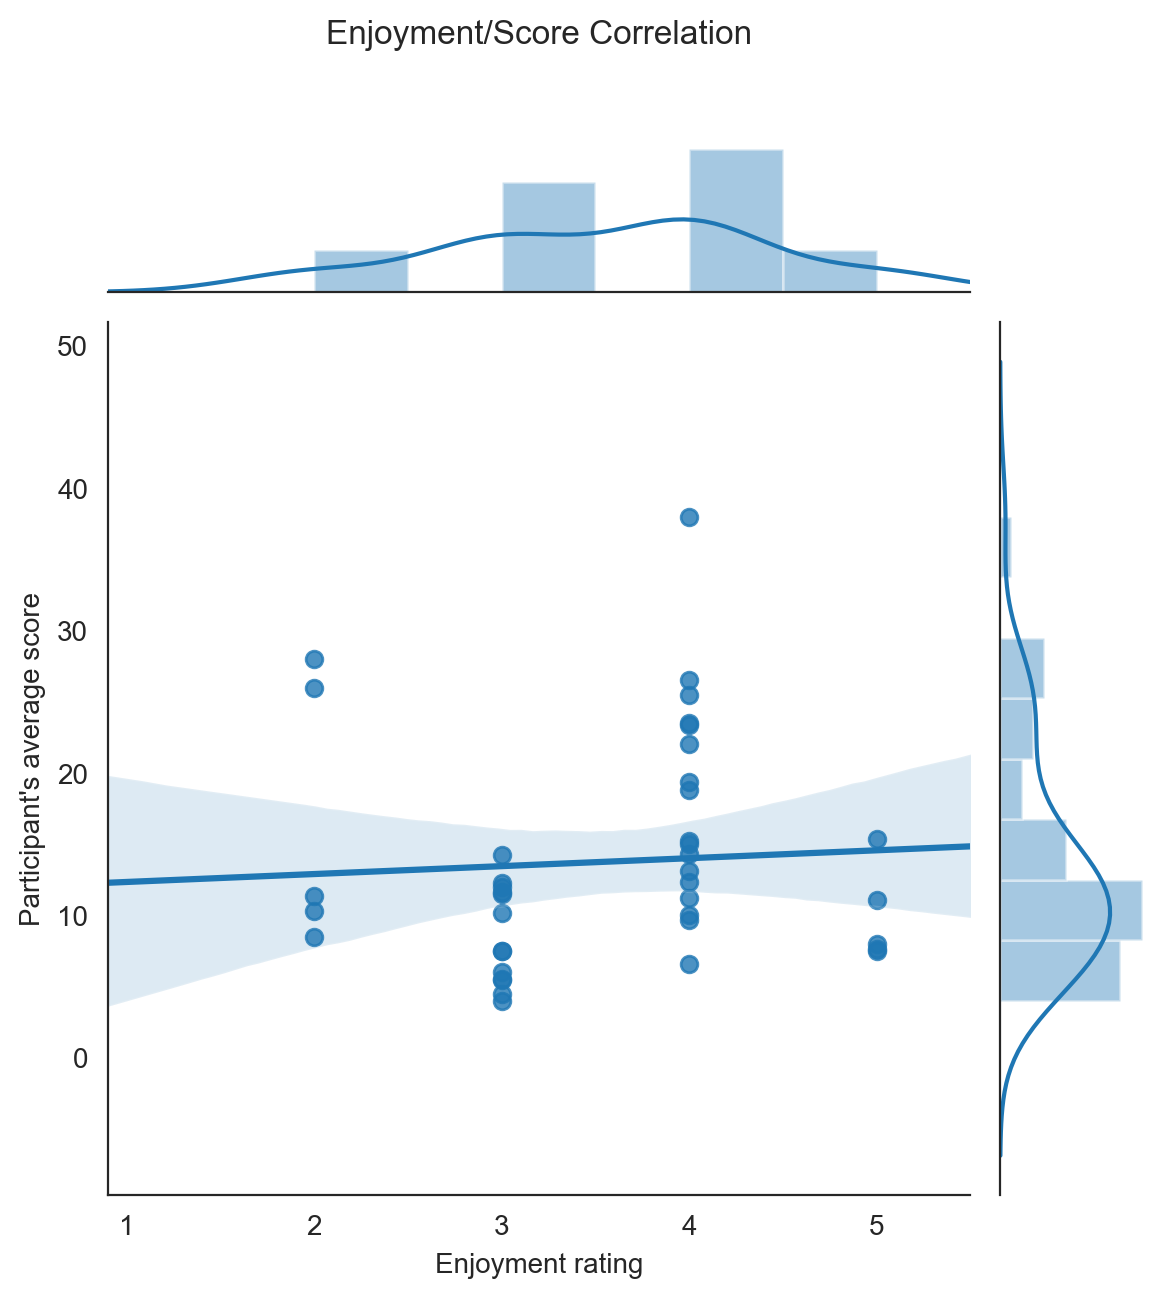

In [333]:
sns.jointplot(variant_df.enjoyment, variant_df.avg_score, kind='regg')
plt.xlim(.9, 5.5)

plt.ylabel("Participant's average score")
plt.xlabel('Enjoyment rating')

plt.title('Enjoyment/Score Correlation', y=1.3)
plt.show()

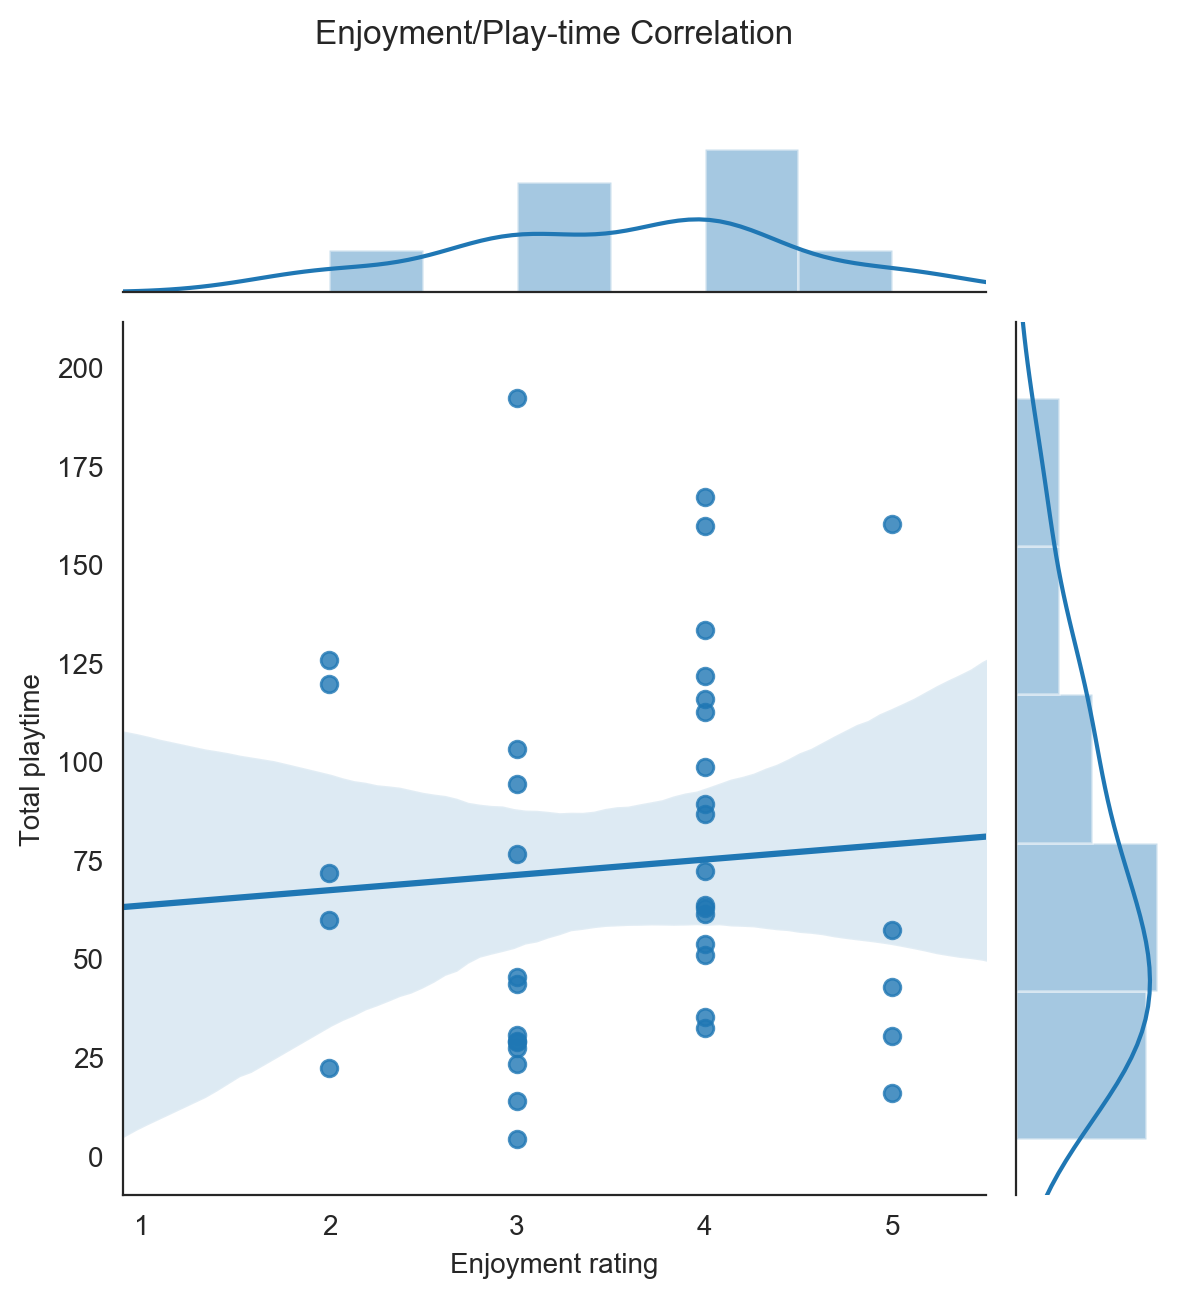

In [346]:
sns.jointplot(variant_df.enjoyment, variant_df.total_duration, kind='regg')
plt.xlim(.9, 5.5)
plt.ylim(-10, max(variant_df.total_duration) * 1.1)

plt.ylabel('Total playtime')
plt.xlabel('Enjoyment rating')

plt.title('Enjoyment/Play-time Correlation', y=1.3)
plt.show()

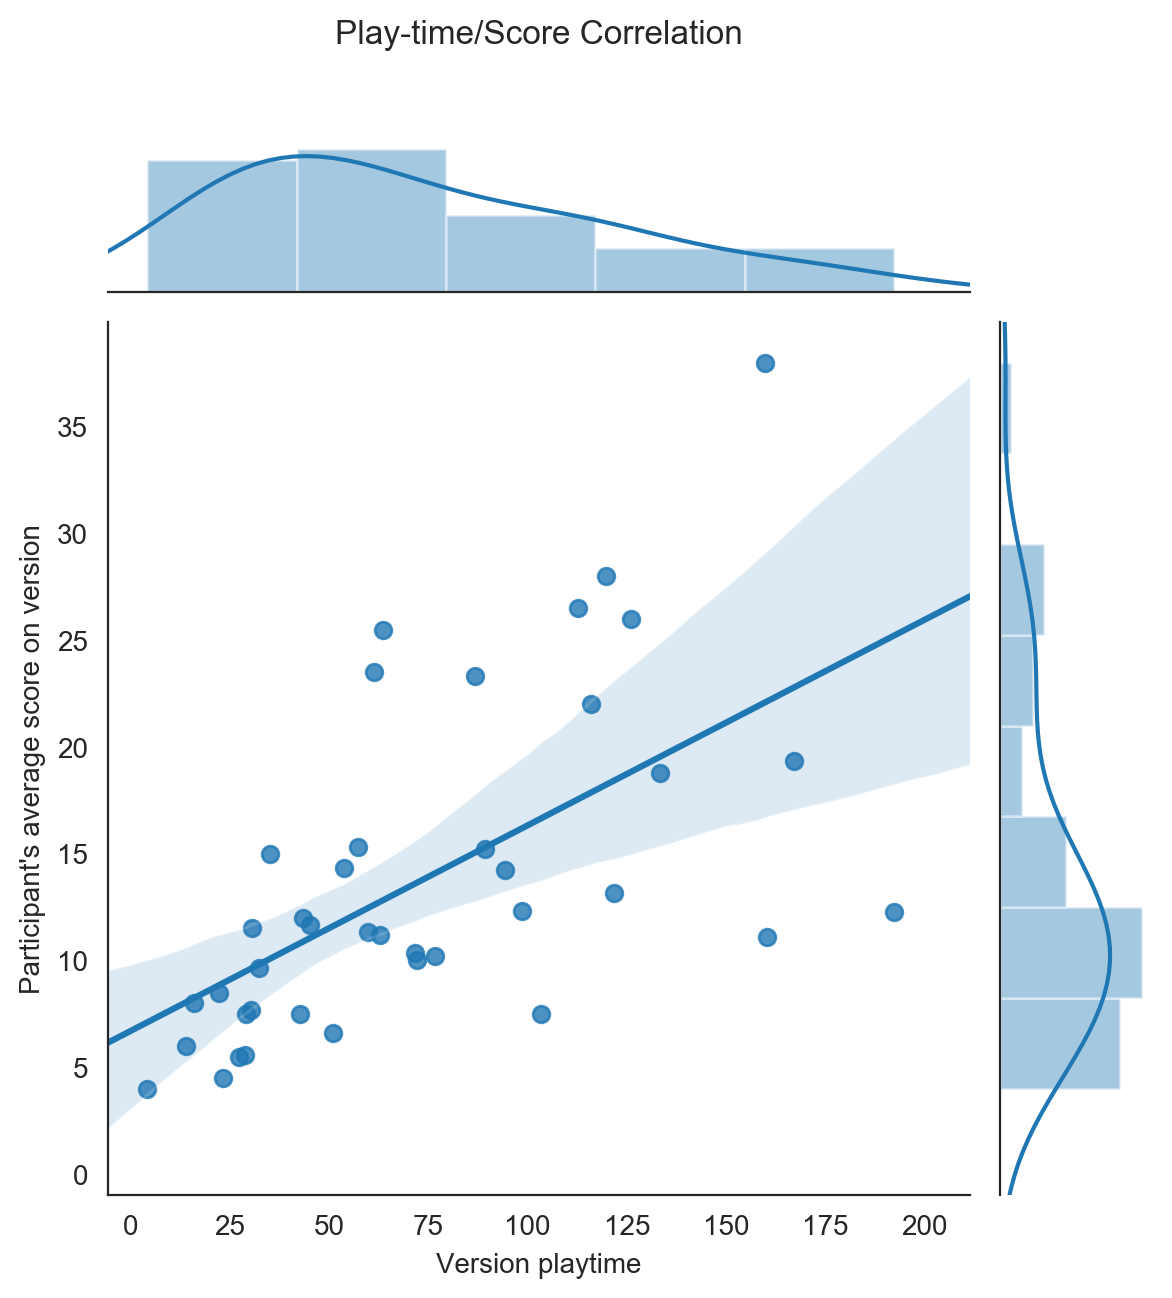

In [345]:
sns.jointplot(variant_df.total_duration, variant_df.avg_score, kind='regg')

plt.xlabel('Version playtime')
plt.ylabel("Participant's average score on version")

plt.ylim(min(variant_df.avg_score) - 5, max(variant_df.avg_score) * 1.05)
plt.xlim(min(variant_df.total_duration) - 10, max(variant_df.total_duration) * 1.1)

plt.title('Play-time/Score Correlation', y=1.3)
plt.show()

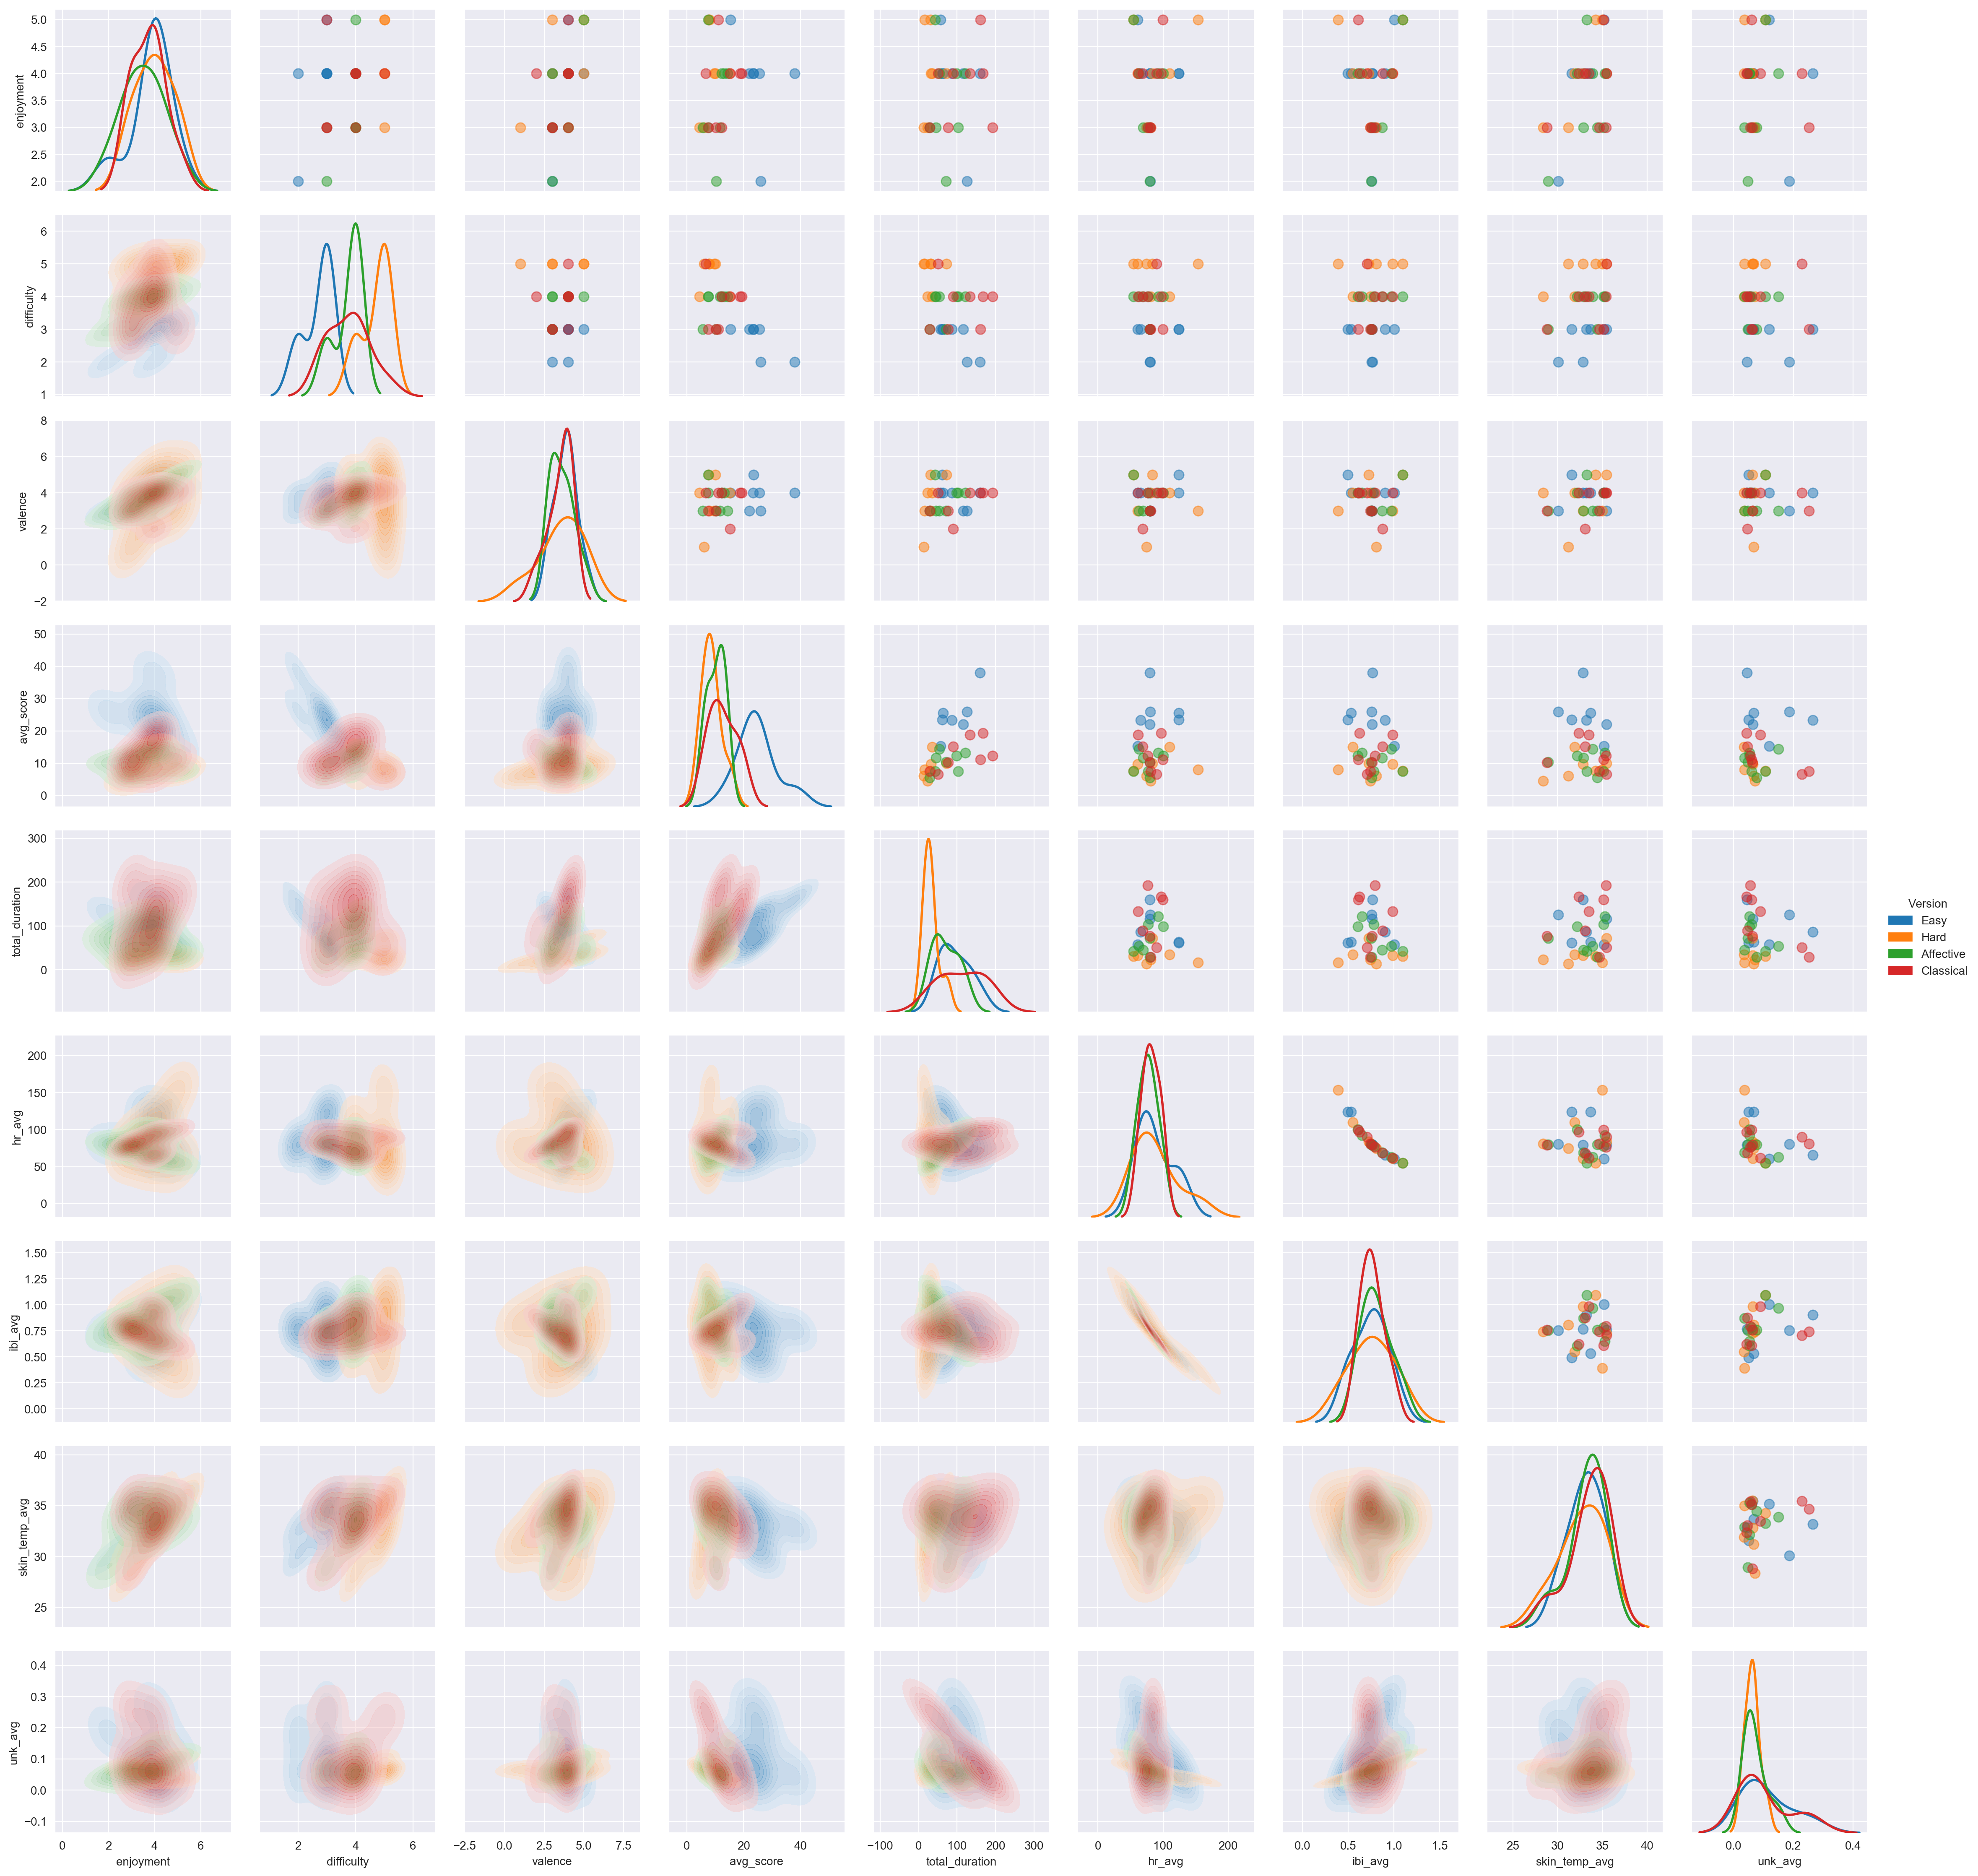

In [747]:
g = sns.PairGrid(variant_df[['enjoyment', 'difficulty', 'valence', 'avg_score', 'total_duration', 'ver', 'hr_avg', 'ibi_avg', 'skin_temp_avg', 'unk_avg']].dropna(), 
                 diag_sharey=False, hue='ver')#, hue_kws={"marker": ["v", "^", '*', "o"]})
    
g.map_upper(plt.scatter, s=70, alpha=.5)
g.map_lower(sns.kdeplot, alpha=.5, shade=True, shade_lowest=False)
g.map_diag(sns.kdeplot, lw=2)

g.add_legend(title='Version')
plt.show()

---

In [414]:
from scipy.signal import savgol_filter

In [530]:
physio_df.describe()

hr          ibi       replay     skin_temp          unk
count  4667.000000  4667.000000  4667.000000   4667.000000  4667.000000
mean     82.999270     0.702765     1.217699     51.000817     0.065329
std      25.241889     0.204278     1.442483   1214.472117     0.059144
min       0.000000     0.000000     0.000000      0.000000     0.000000
25%      71.107830     0.609400     0.000000     32.490000     0.038420
50%      81.698330     0.718780     1.000000     33.390000     0.052600
75%      95.995530     0.828160     2.000000     35.410000     0.069410
max     174.537300     1.234430     9.000000  83000.000000     0.490000

---

TODO: 
 - [ ] correlation between declared skill and score
 - [ ] correlation between declared competitiveness and enjoyment of perceived difficulty

In [900]:
user_df_ = user_df.sort_values(by='pseudonym').dropna()

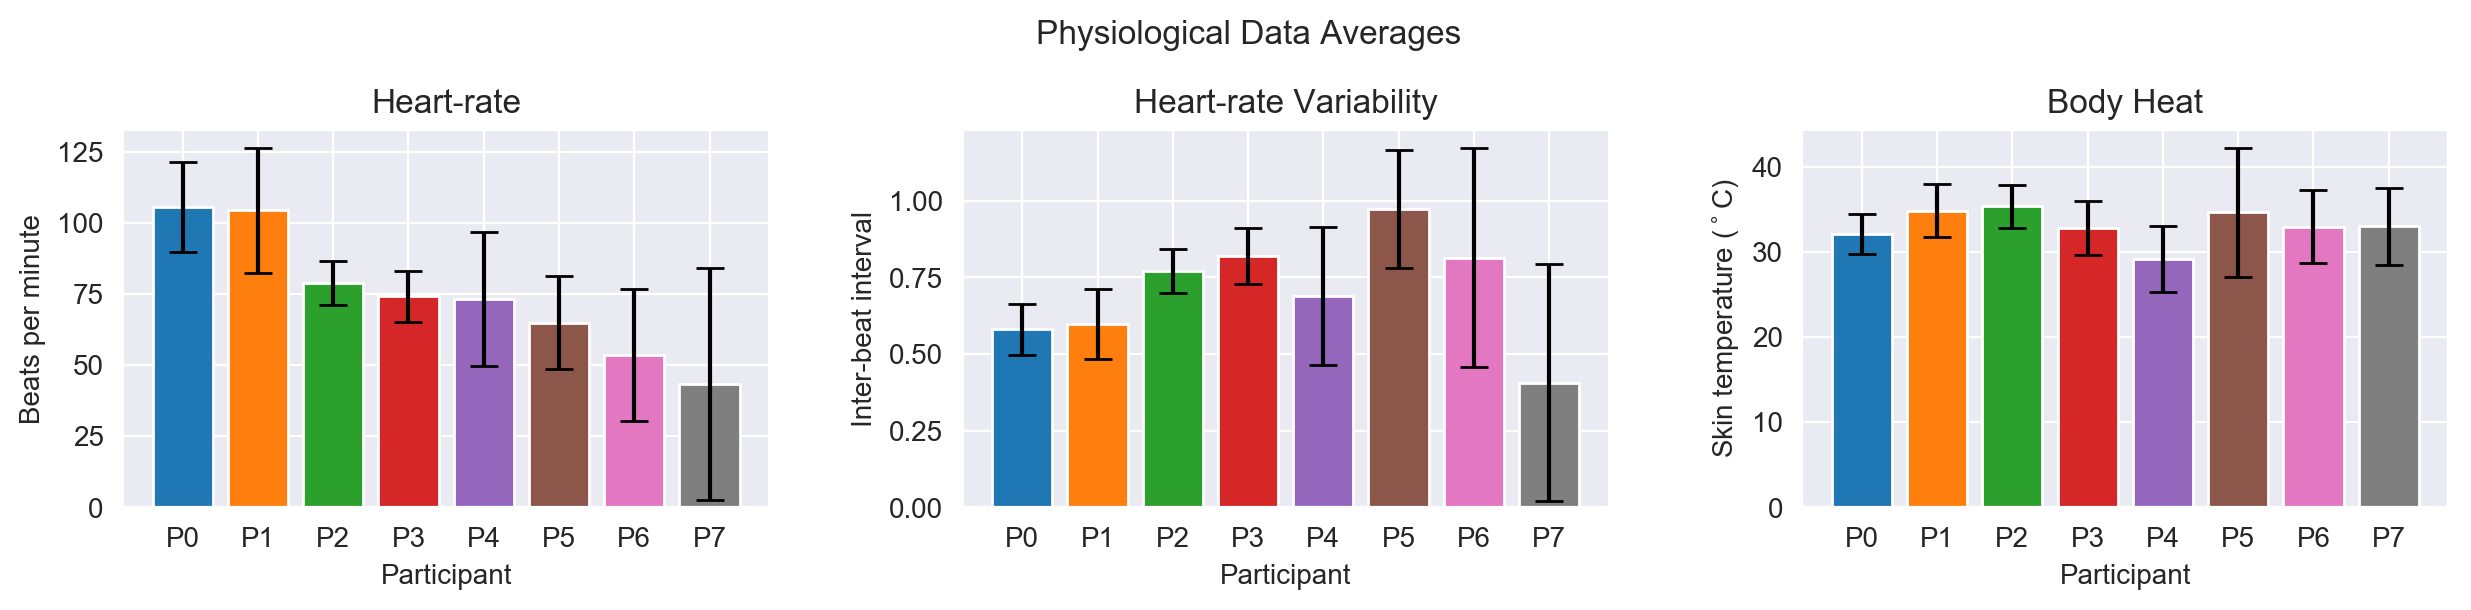

In [802]:
plt.figure(figsize=(15, 2.5))

for k, (col, title, unit) in enumerate(zip(
    ['hr', 'ibi', 'skin_temp'],
    ['Heart-rate', 'Heart-rate Variability', 'Body Heat'],
    ['Beats per minute', 'Inter-beat interval', 'Skin temperature ($^\circ$C)']
)):
    plt.subplot(1, 3, k+1)
    plt.bar(user_df_.pseudonym, 
            user_df_[col + '_avg'], 
            yerr=user_df_[col + '_std'], 
            capsize=5, color=[f'C{u[1:]}' for u in user_df_.pseudonym])
    
    plt.title(title)
    plt.ylabel(unit)
    plt.xlabel('Participant')
    
plt.subplots_adjust(wspace=.3)
plt.suptitle('Physiological Data Averages', y=1.1)
plt.show()

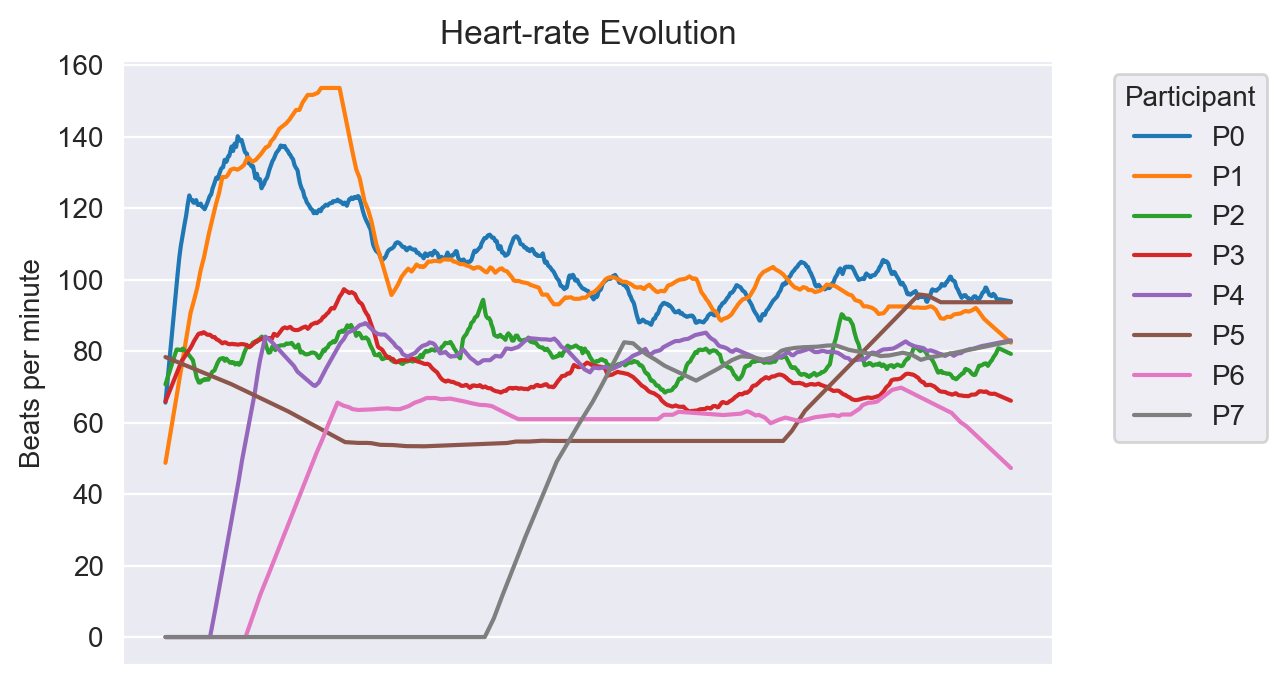

In [711]:
for user, rows in physio_df.groupby('pseudonym'):
    smoothened = savgol_filter(rows.hr, window_length=31, polyorder=1)
    plt.plot(np.linspace(0, 1, len(rows.hr)), smoothened, label=user, c=f'C{user[1:]}')

plt.legend(title='Participant', bbox_to_anchor=(1.05, 1))
plt.ylabel('Beats per minute')
plt.xticks([])
plt.title('Heart-rate Evolution')
plt.show()

last two do not have hr info

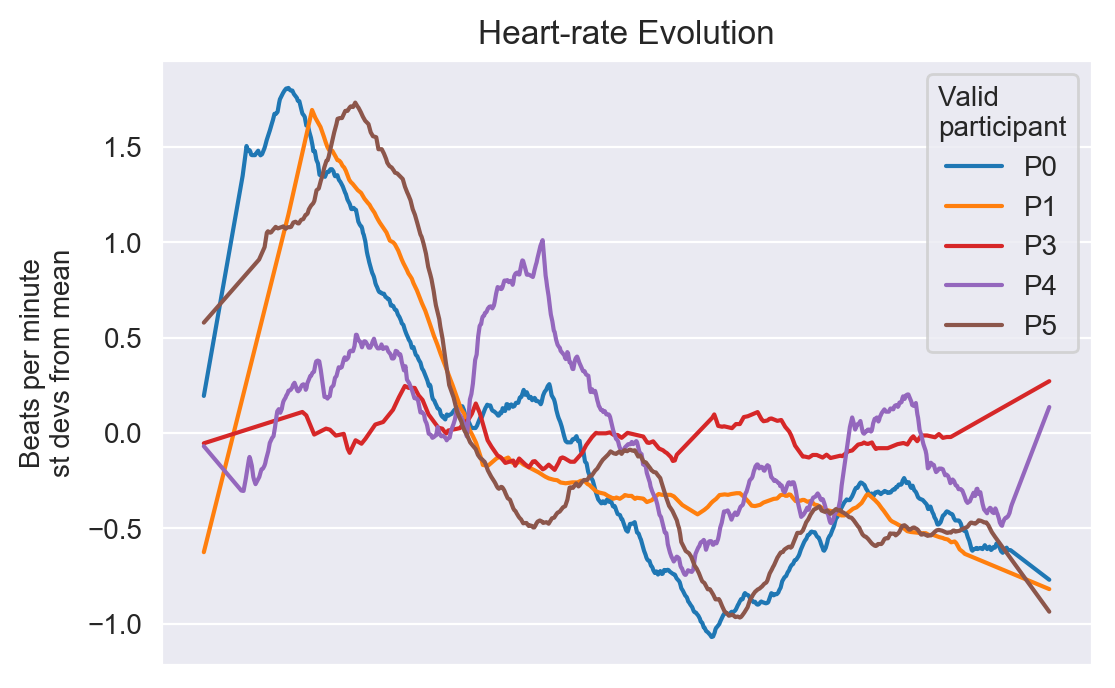

In [781]:
for user, rows in physio_df.groupby('pseudonym'):
    data = rows.hr
    n_skip = int(len(data) * .01)  # skip first 1% that contain initialization measurement errors
    data = data[n_skip:]
    
    if len(data) < 300:
        continue  # don't plot people with invalid data

    data -= data.mean()
    data /= data.std()

    smoothened = savgol_filter(data, window_length=101, polyorder=1)
    plt.plot(np.linspace(0, 1, len(data)), smoothened, label=user, c=f'C{user[1:]}')

plt.legend(title='Valid\nparticipant')
plt.ylabel('Beats per minute\nst devs from mean')
plt.xticks([])
plt.title('Heart-rate Evolution')
plt.show()

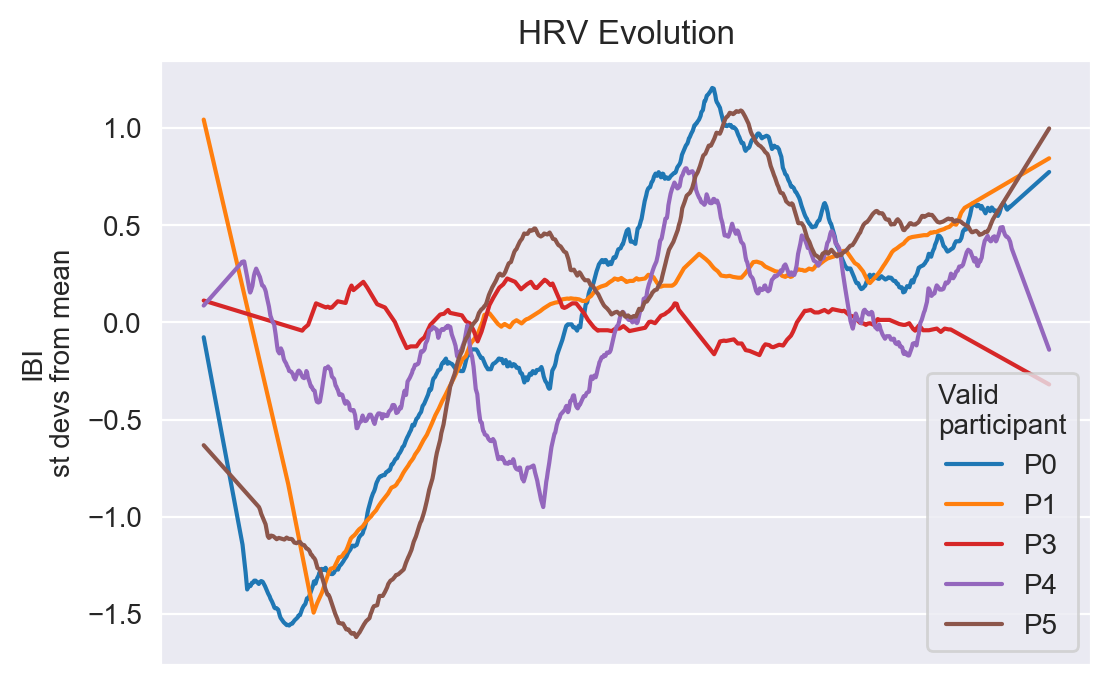

In [800]:
for user, rows in physio_df.groupby('pseudonym'):
    data = rows.ibi
    n_skip = int(len(data) * .01)  # skip first 1% that contain initialization measurement errors
    data = data[n_skip:]
    
    if len(data) < 300:
        continue  # don't plot people with invalid data

    data -= data.mean()
    data /= data.std()

    smoothened = savgol_filter(data, window_length=101, polyorder=1)
    plt.plot(np.linspace(0, 1, len(data)), smoothened, label=user, c=f'C{user[1:]}')

plt.legend(title='Valid\nparticipant')
plt.ylabel('IBI\nst devs from mean')
plt.xticks([])
plt.title('HRV Evolution')
plt.show()

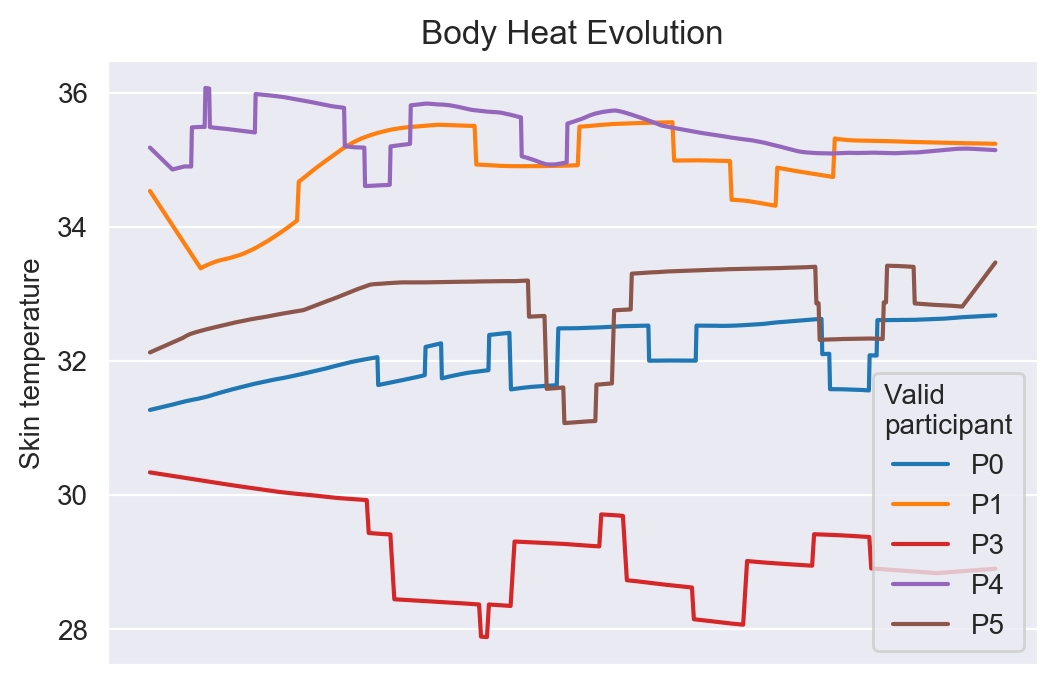

In [798]:
for user, rows in physio_df.groupby('pseudonym'):
    data = rows.skin_temp
    n_skip = int(len(data) * .01)  # skip first 1% that contain initialization measurement errors
    data = data[n_skip:]
    
    if len(data) < 300:
        continue  # don't plot people with invalid data

    smoothened = savgol_filter(data, window_length=61, polyorder=1)
    plt.plot(np.linspace(0, 1, len(data)), smoothened, label=user, c=f'C{user[1:]}')

plt.legend(title='Valid\nparticipant')
plt.ylabel('Skin temperature')
plt.xticks([])
plt.title('Body Heat Evolution')
plt.show()

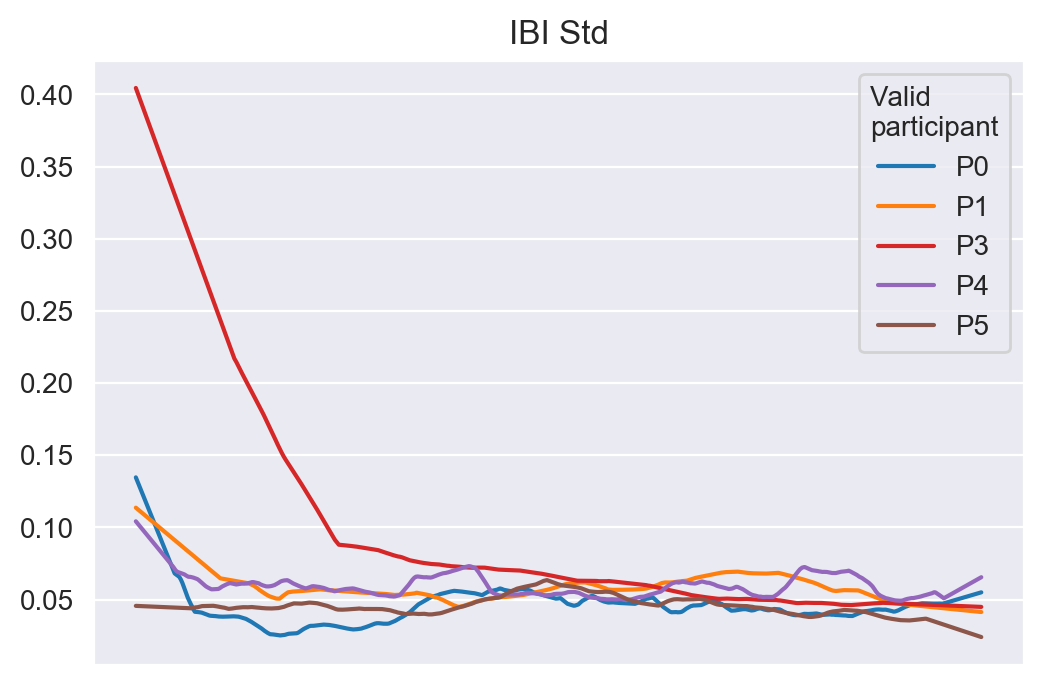

In [804]:
for user, rows in physio_df.groupby('pseudonym'):
    data = rows.unk
    n_skip = int(len(data) * .01)  # skip first 1% that contain initialization measurement errors
    data = data[n_skip:]
    
    if len(data) < 300:
        continue  # don't plot people with invalid data

    smoothened = savgol_filter(data, window_length=101, polyorder=1)
    plt.plot(np.linspace(0, 1, len(data)), smoothened, label=user, c=f'C{user[1:]}')

plt.legend(title='Valid\nparticipant')
# plt.ylabel('???')
plt.xticks([])
plt.title('IBI Std')
plt.show()

---

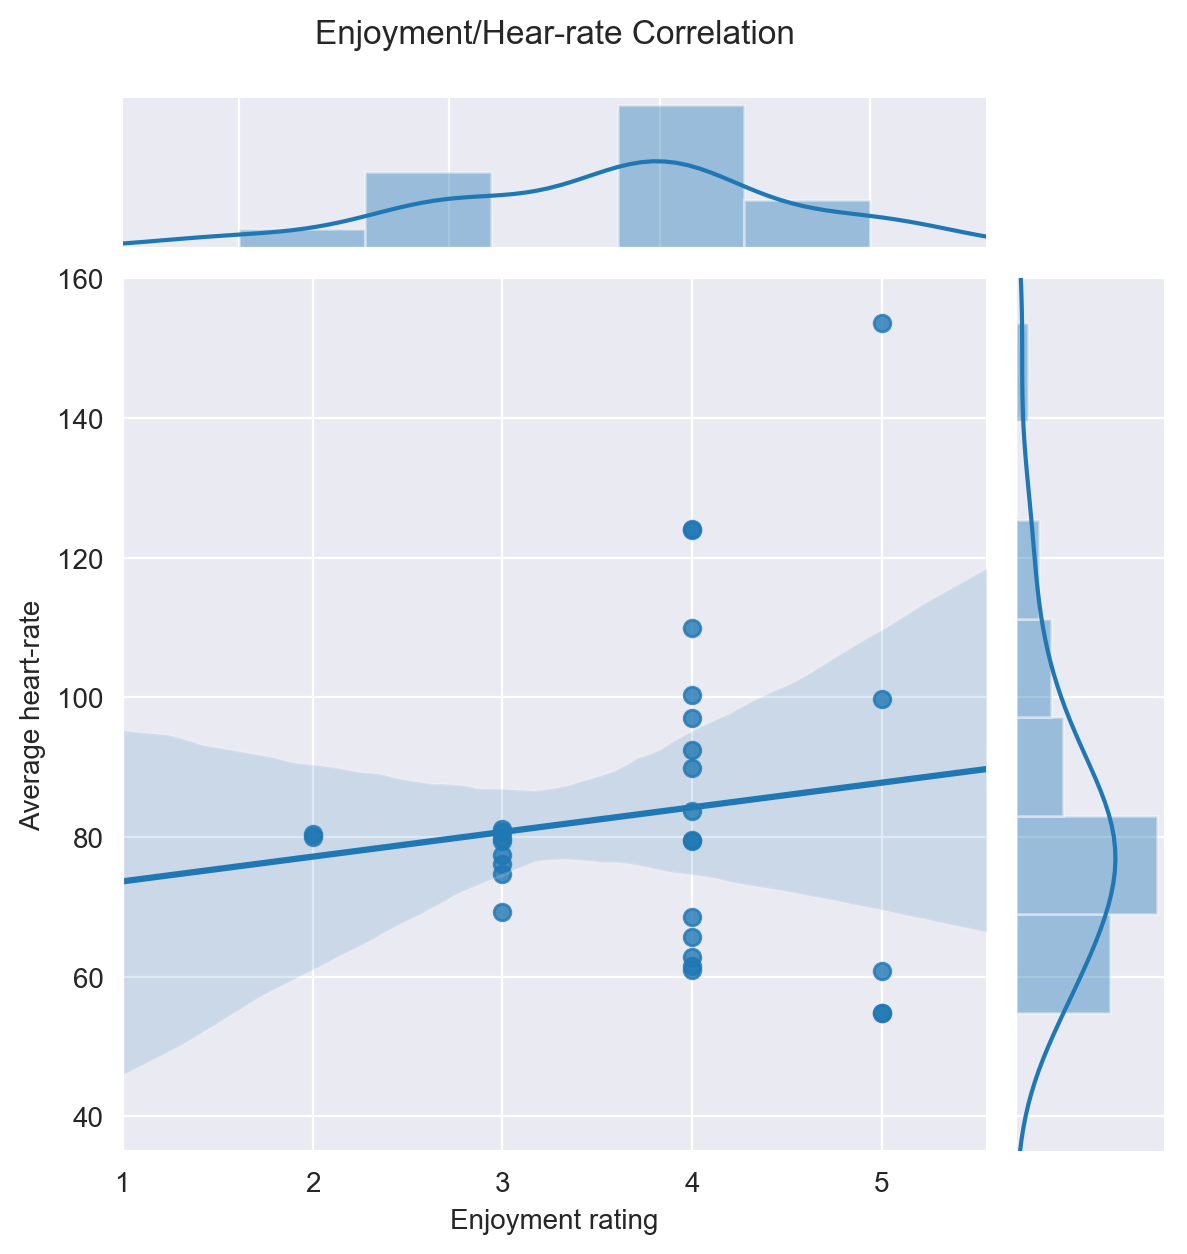

In [850]:
sns.jointplot(variant_df.enjoyment, variant_df.hr_avg, kind='regg')

plt.xlim(1.45, 5.55)
plt.gca().set_xticks(range(1, 6))
plt.ylim(35, 160)

plt.ylabel('Average heart-rate')
plt.xlabel('Enjoyment rating')
plt.title('Enjoyment/Hear-rate Correlation', y=1.25)

plt.show()

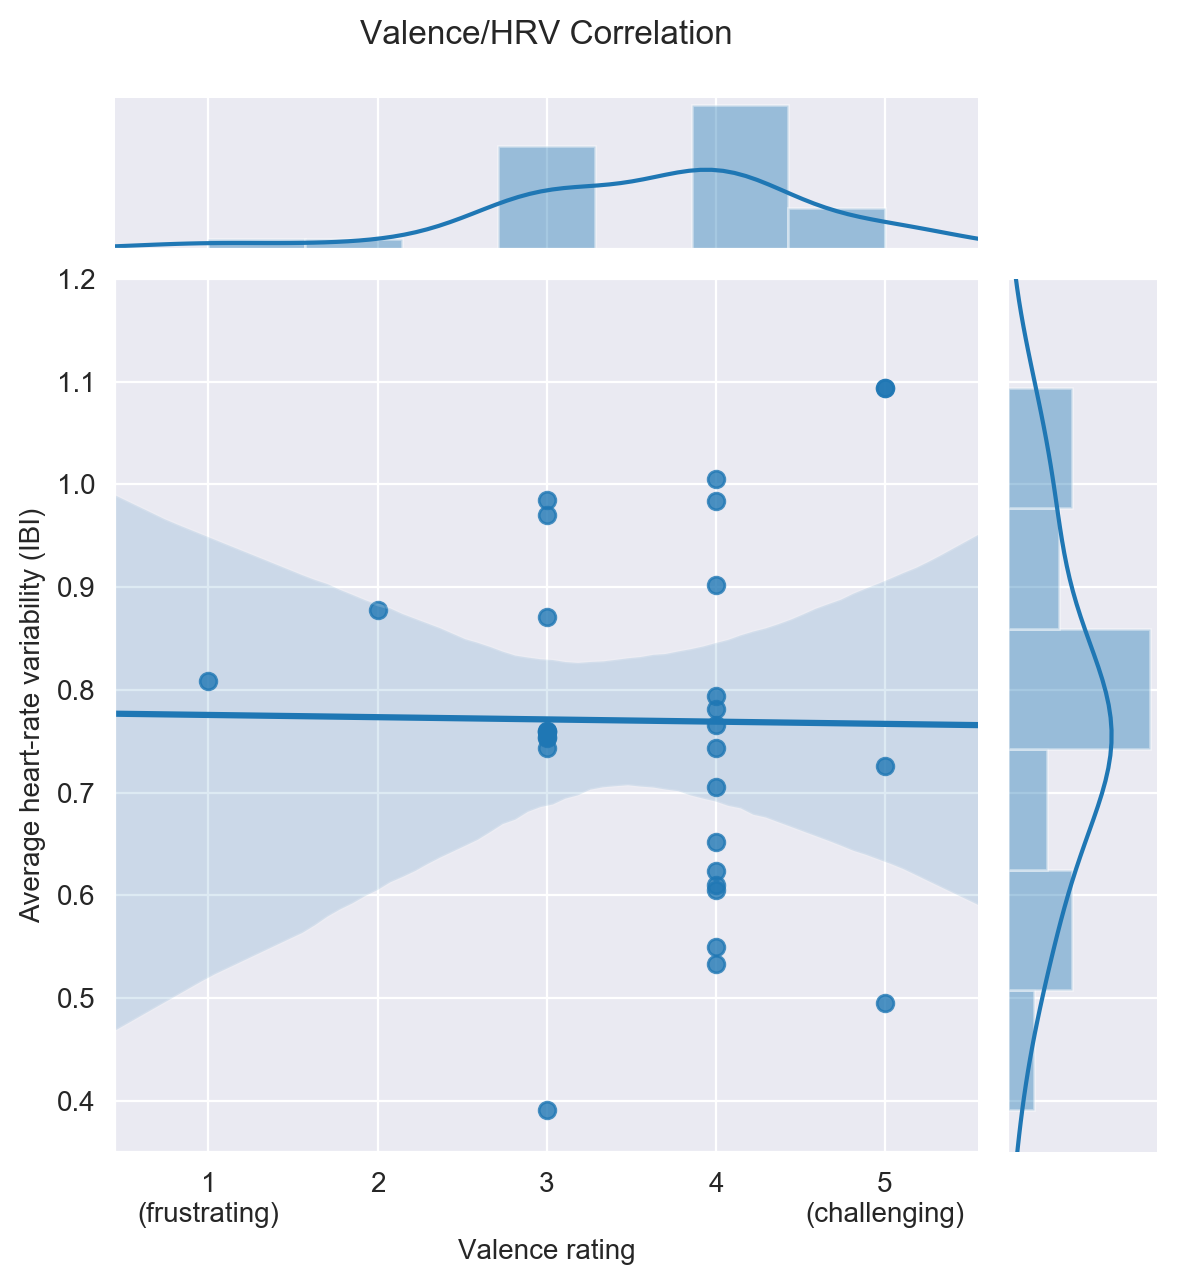

In [766]:
sns.jointplot(variant_df.valence, variant_df.ibi_avg, kind='regg')

plt.xlim(.45, 5.55)
plt.gca().set_xticks(range(1, 6))
plt.ylim(.35, 1.2)

plt.ylabel('Average heart-rate variability (IBI)')
plt.xlabel('Valence rating')
plt.gca().set_xticklabels([
    '1\n(frustrating)',
    '2',
    '3',
    '4',
    '5\n(challenging)'
])
plt.title('Valence/HRV Correlation', y=1.25)

plt.show()

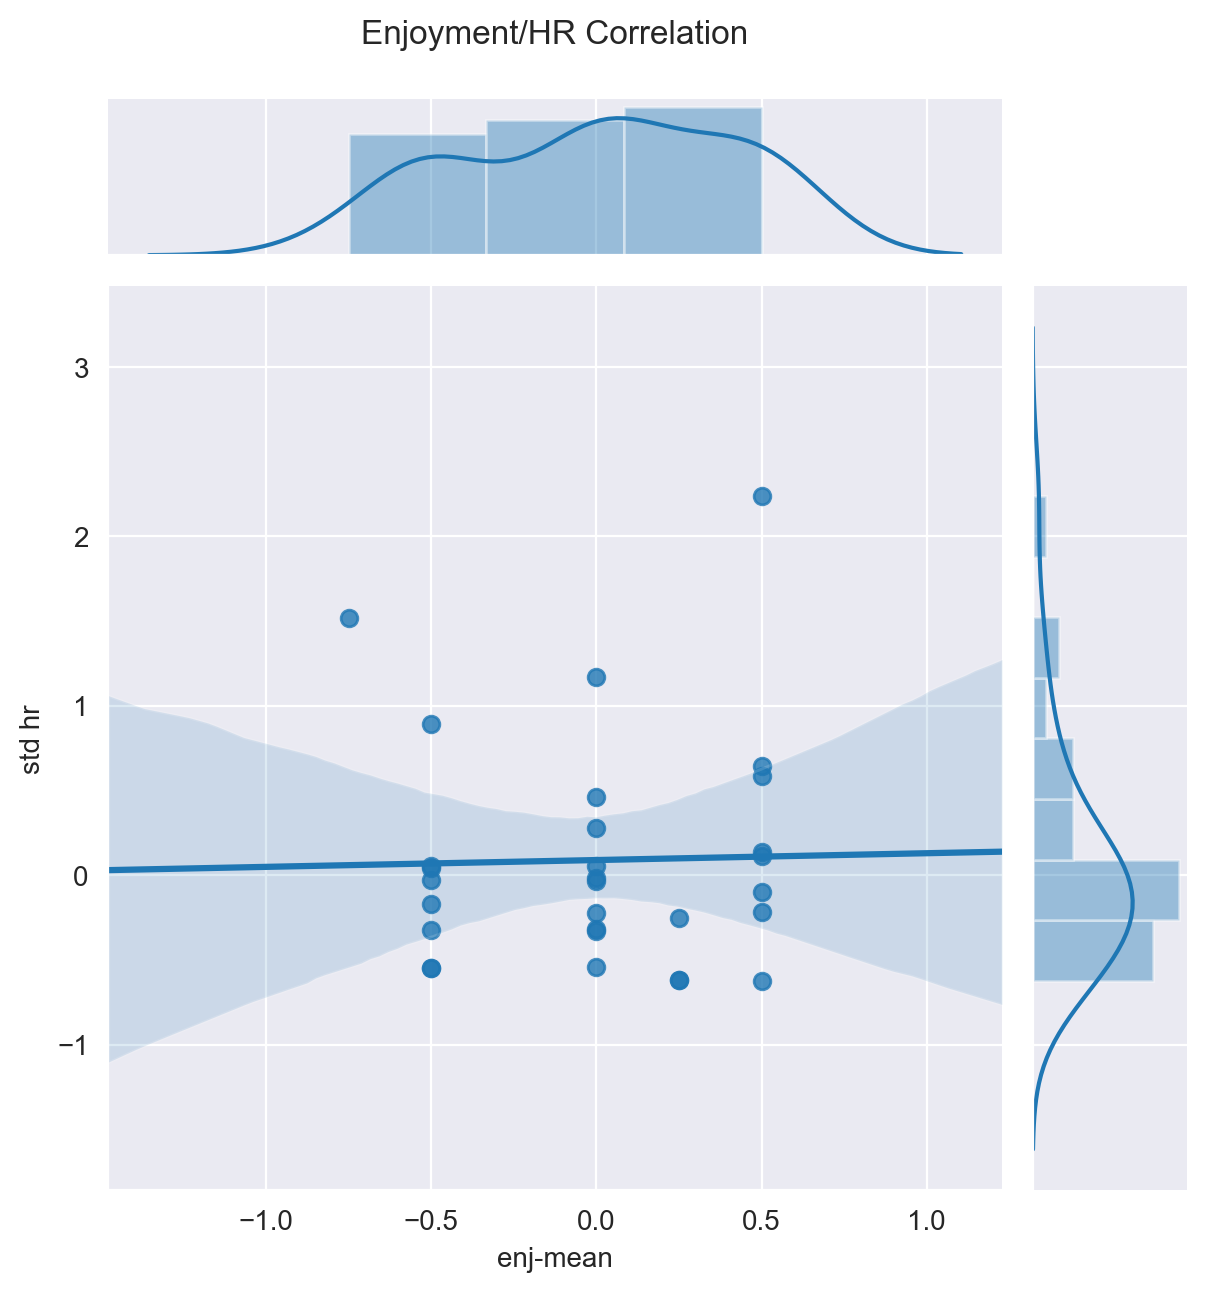

In [853]:
xs = []
ys = []

for (u, ver), rows in variant_df.groupby(['user', 'ver']):
    overall_hr = physio_df[physio_df.user == u].hr
    standardized_hr = (rows.hr_avg[0] - overall_hr.mean()) / overall_hr.std()
    
    overall_enj = variant_df[variant_df.user == u].enjoyment
    standardized_enj = rows.enjoyment[0] - overall_enj.mean()
    
    if np.isnan(standardized_enj) or np.isnan(standardized_hr):
        continue
    
    xs.append(standardized_enj)
    ys.append(standardized_hr)

sns.jointplot(xs, ys, kind='regg')

plt.ylabel('std hr')
plt.xlabel('enj-mean')

plt.title('Enjoyment/HR Correlation', y=1.25)

plt.show()

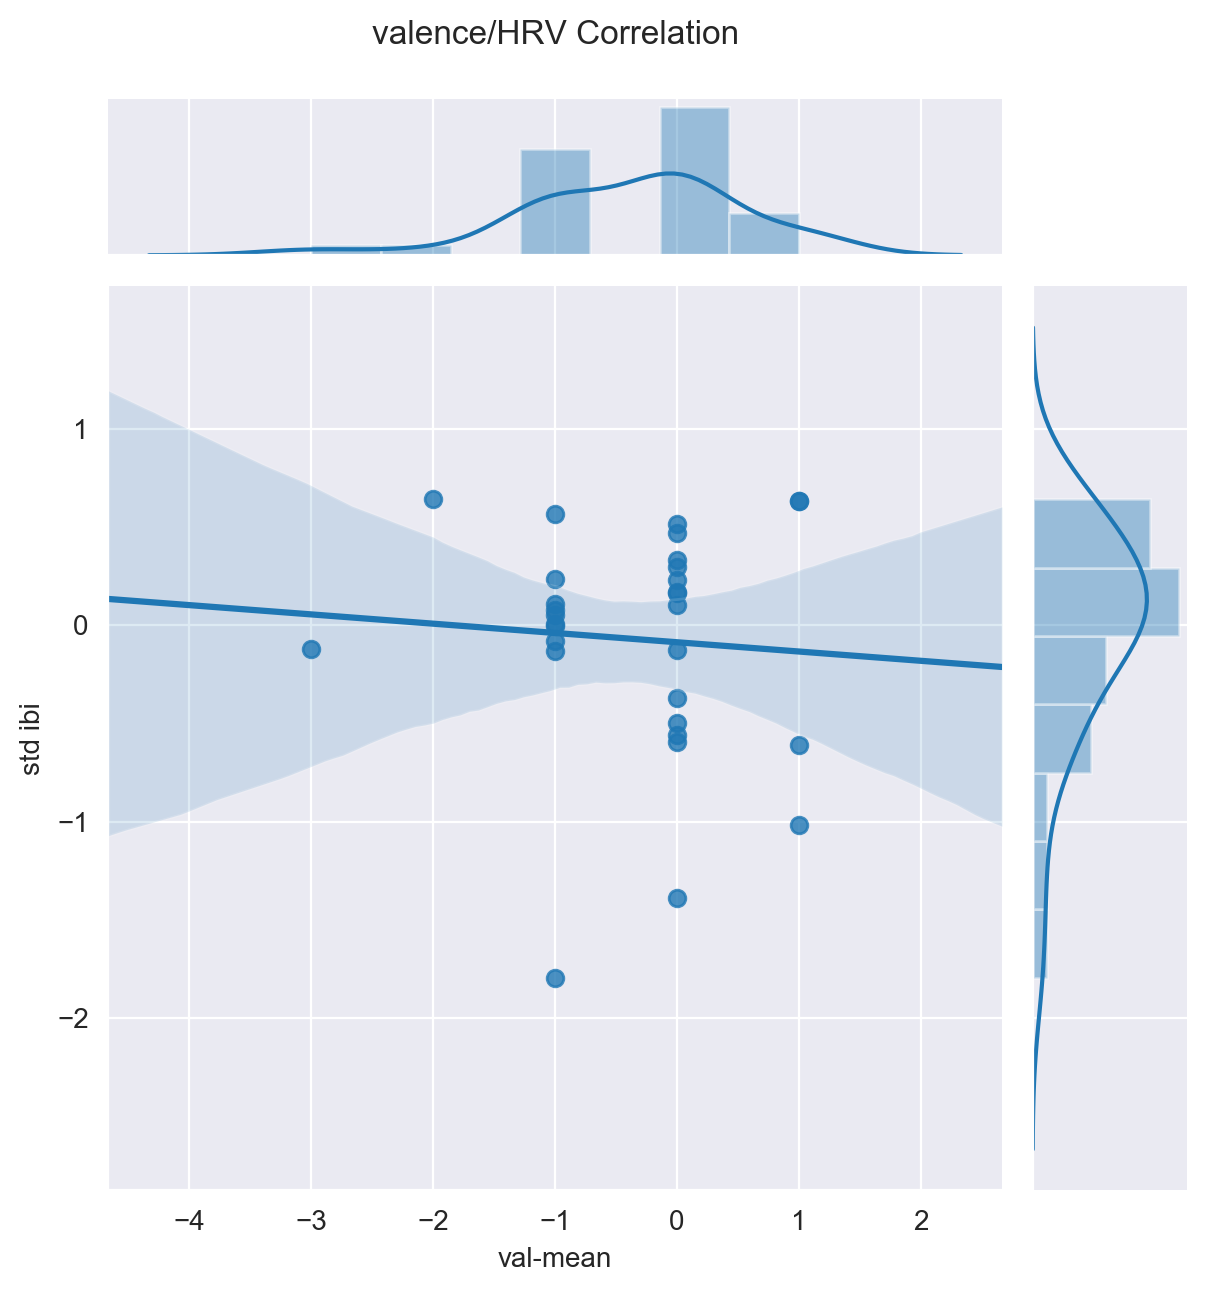

In [856]:
xs = []
ys = []

for (u, ver), rows in variant_df.groupby(['user', 'ver']):
    overall_ibi = physio_df[physio_df.user == u].ibi
    standardized_ibi = (rows.ibi_avg[0] - overall_ibi.mean()) / overall_ibi.std()
    
    overall_val = variant_df[variant_df.user == u].valence
    standardized_val = rows.valence[0] - overall_enj.mean()
    
    if np.isnan(standardized_val) or np.isnan(standardized_ibi):
        continue
    
    xs.append(standardized_val)
    ys.append(standardized_ibi)

sns.jointplot(xs, ys, kind='regg')

plt.ylabel('std ibi')
plt.xlabel('val-mean')

plt.title('valence/HRV Correlation', y=1.25)

plt.show()

---

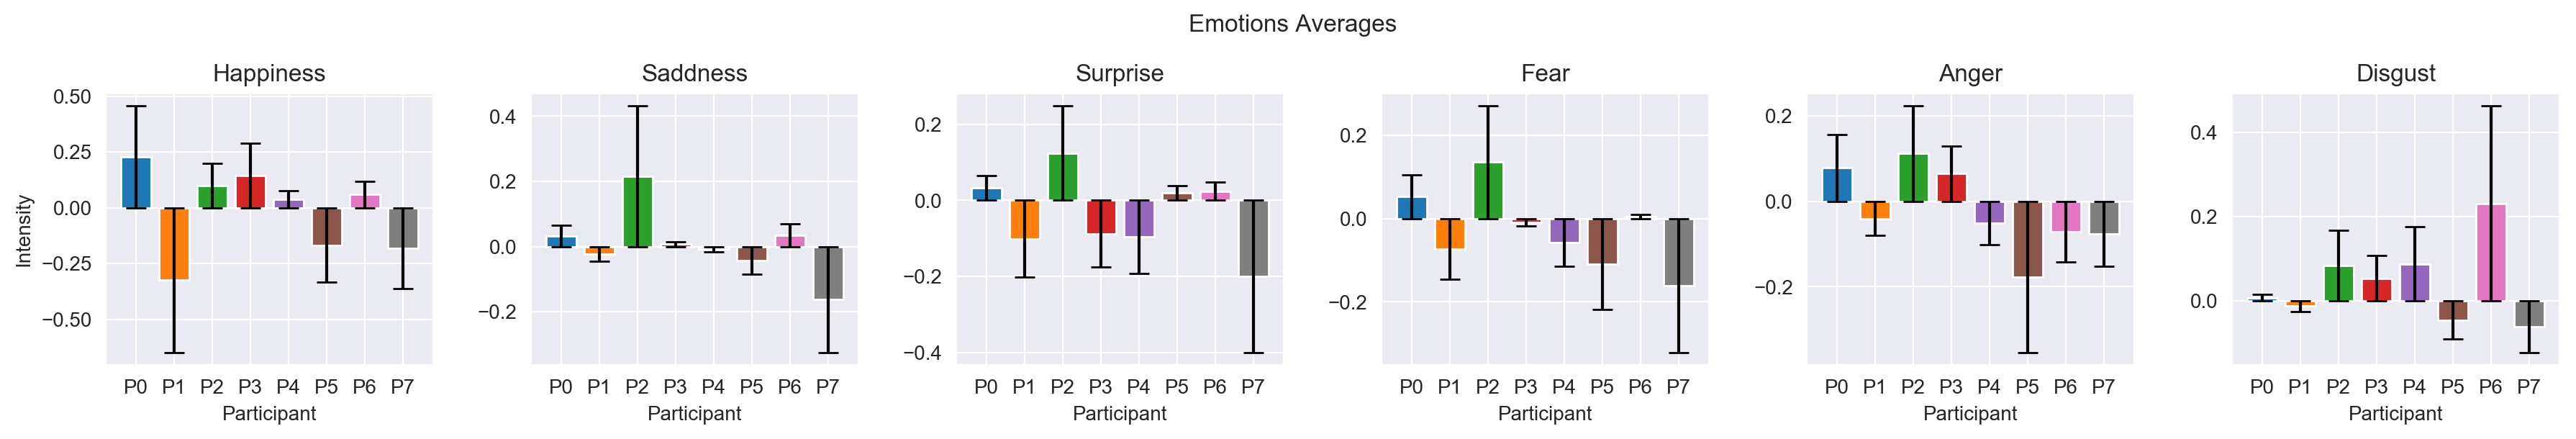

In [904]:
plt.figure(figsize=(22, 2.5))

for k, col in enumerate(EMO_DIMS):
    plt.subplot(1, len(EMO_DIMS), k+1)
    plt.bar(user_df_.pseudonym, 
            user_df_[col + '_avg'], 
            yerr=user_df_[col + '_std'], 
            capsize=5, color=[f'C{u[1:]}' for u in user_df_.pseudonym])
    
    plt.title(col.title())
    if k == 0:
        plt.ylabel('Intensity')
    plt.xlabel('Participant')
    
plt.subplots_adjust(wspace=.3)
plt.suptitle('Emotions Averages', y=1.1)
plt.show()

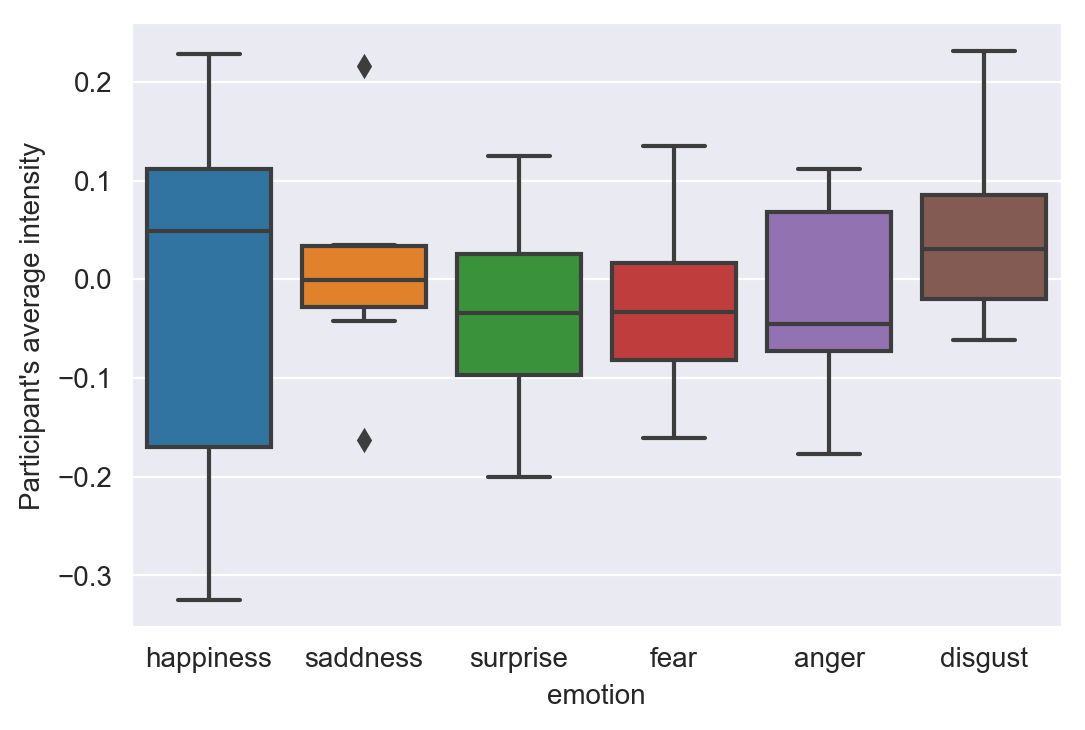

In [919]:
sns.boxplot(x='emotion', y='intensity', data=
           pd.melt(
                user_df_, 
                id_vars='pseudonym', 
                value_vars=[c + '_avg' for c in EMO_DIMS],
                var_name='emotion',
                value_name='intensity',
            ))

plt.gca().set_xticklabels(EMO_DIMS)
plt.ylabel("Participant's average intensity")

plt.show()

In [987]:
def no_leading_fmt(x: float, prec=2) -> str:
    x = round(x, prec)
    
    neg = False
    if x < 0:
        neg = True
        x *= -1
        
    if x == 0:
        return '0'
    
    s = str(x).lstrip('0')
    if neg:
        s = '-' + s
    return s

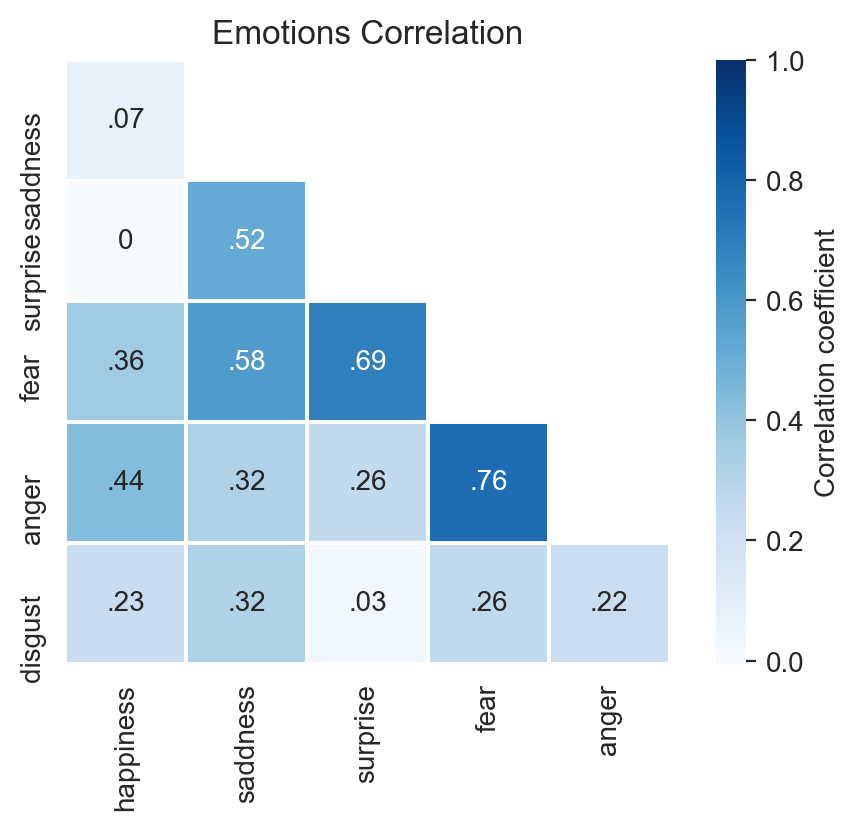

In [1037]:
corr = emo_df[EMO_DIMS].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

corr = corr.iloc[1:, :-1]
mask = mask[1:, :-1]
labels = corr.applymap(no_leading_fmt)

with sns.axes_style('white'):
    ax = sns.heatmap(corr, mask=mask, square=True, 
                     cmap='Blues', linewidth=1,
                     annot=labels.values, fmt='s',
                     cbar_kws=dict(label='Correlation coefficient')
                    )
    
plt.title('Emotions Correlation')
plt.show()

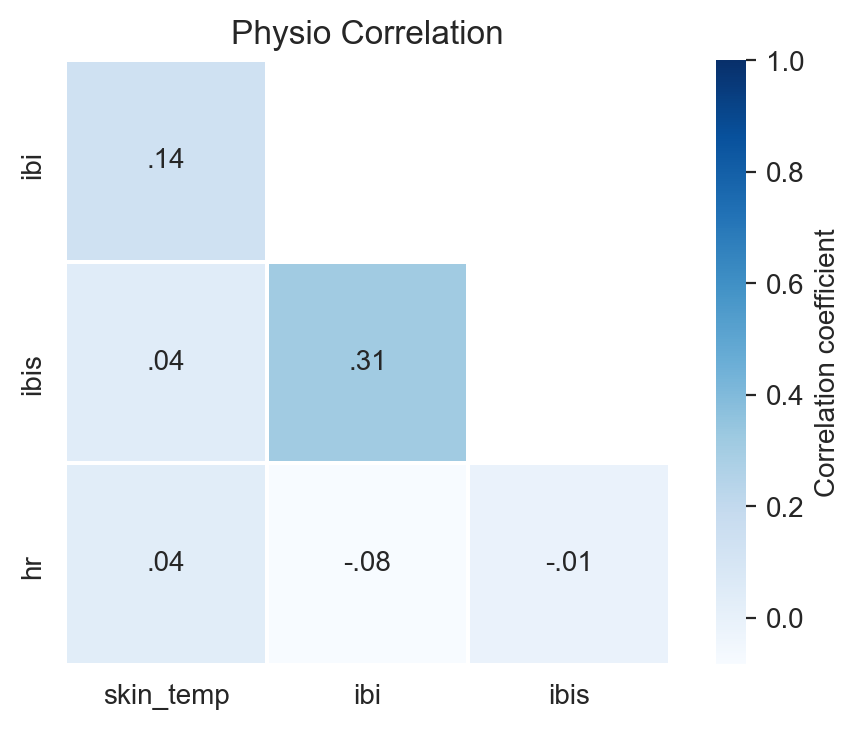

In [989]:
corr = physio_df[PHYSIO_DIMS].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

corr = corr.iloc[1:, :-1]
mask = mask[1:, :-1]
labels = corr.applymap(no_leading_fmt)

with sns.axes_style('white'):
    ax = sns.heatmap(corr, mask=mask, square=True, 
                     cmap='Blues', linewidth=1,
                     annot=labels.values, fmt='s',
                     cbar_kws=dict(label='Correlation coefficient')
                    )
    
plt.title('Physio Correlation')
plt.show()

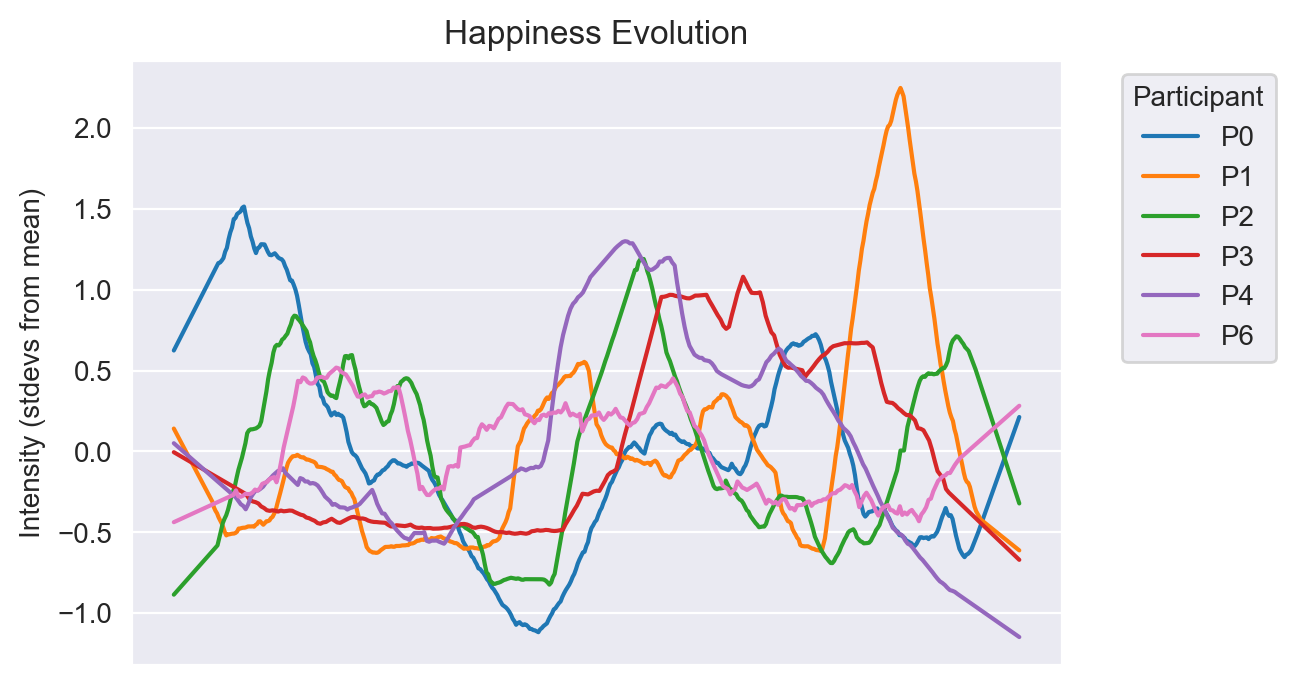

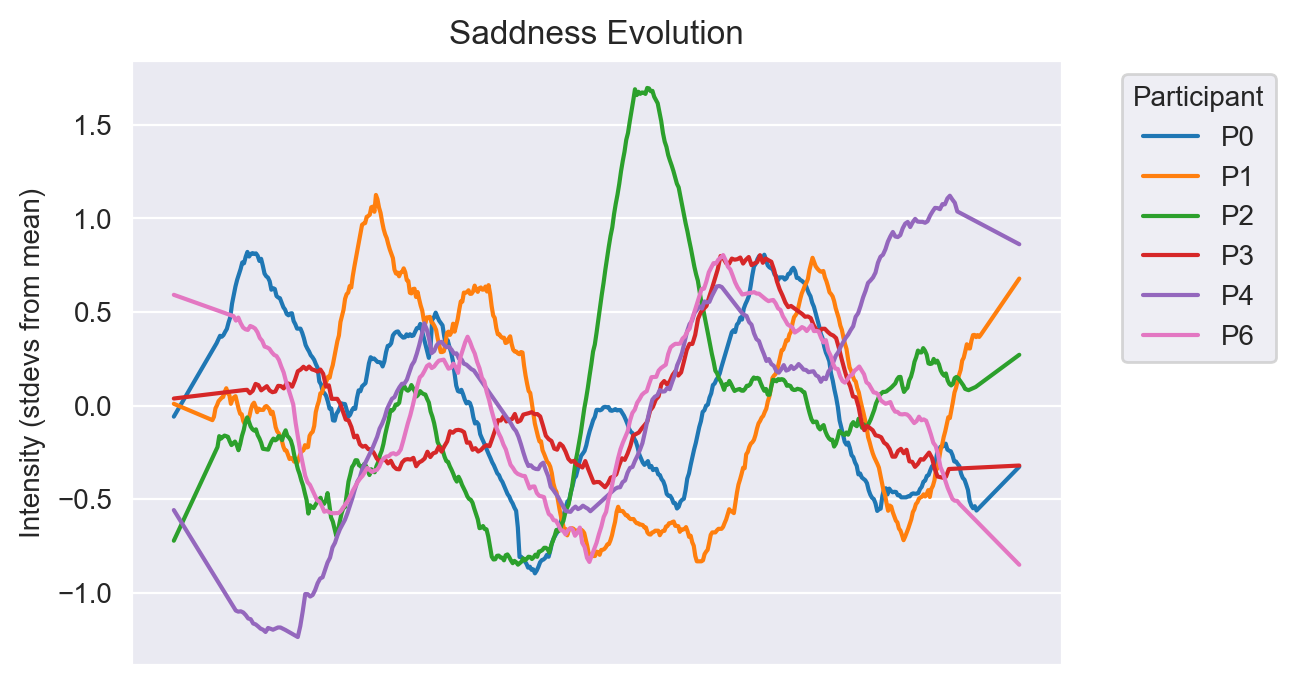

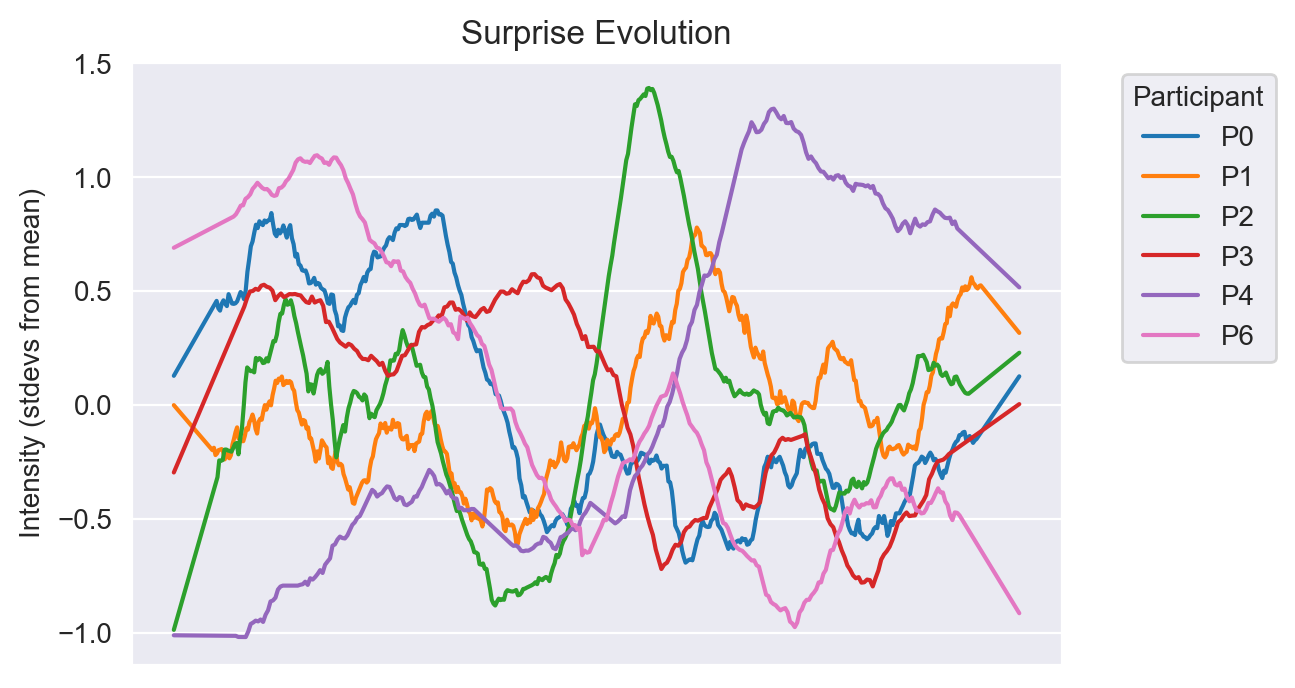

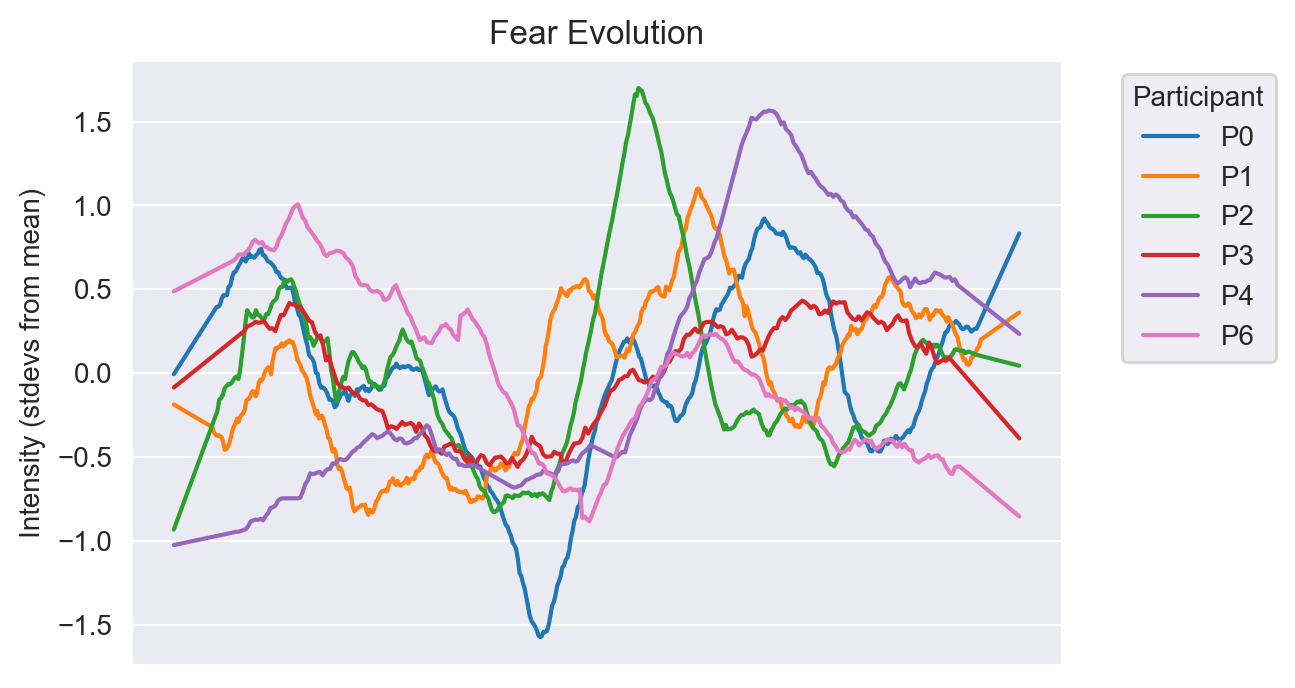

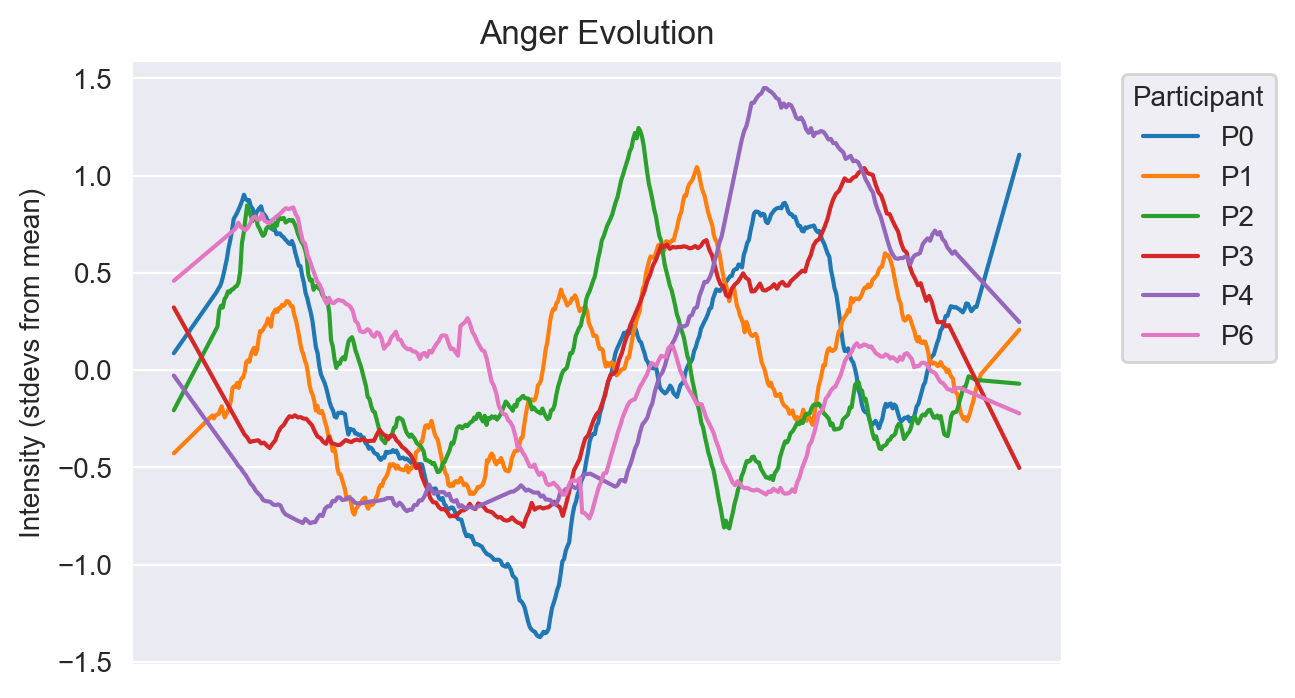

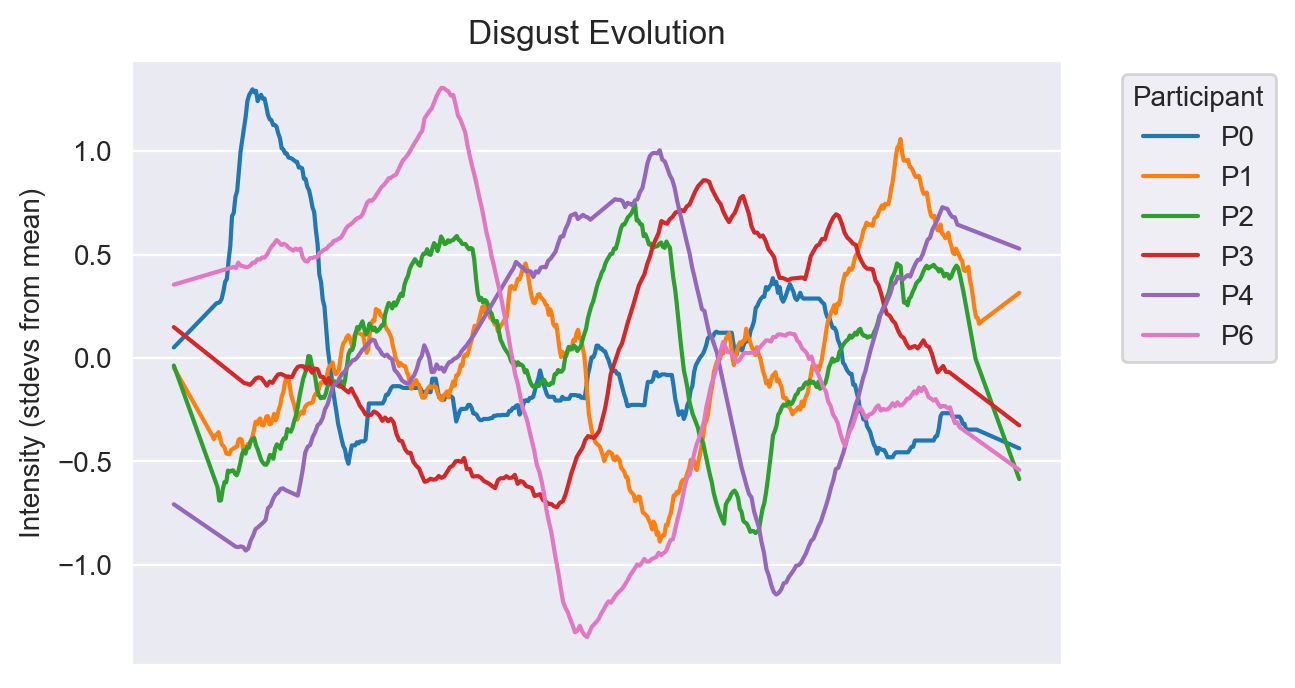

In [934]:
for col in EMO_DIMS:

    for user, rows in emo_df.groupby('pseudonym'):
        data = rows[col]
        n_skip = int(len(data) * .05)  # skip first 1% that contain initialization measurement errors
        data = data[n_skip:]

        if len(data) < 300:
            continue  # don't plot people with invalid data

        data -= data.mean()
        data /= data.std()

        smoothened = savgol_filter(data, window_length=51, polyorder=1)
        plt.plot(np.linspace(0, 1, len(data)), smoothened, label=user, c=f'C{user[1:]}')

    plt.legend(title='Participant', bbox_to_anchor=(1.05, 1))
    plt.ylabel('Intensity (stdevs from mean)')
    plt.xticks([])
    plt.title(col.title() + ' Evolution')
    plt.show()

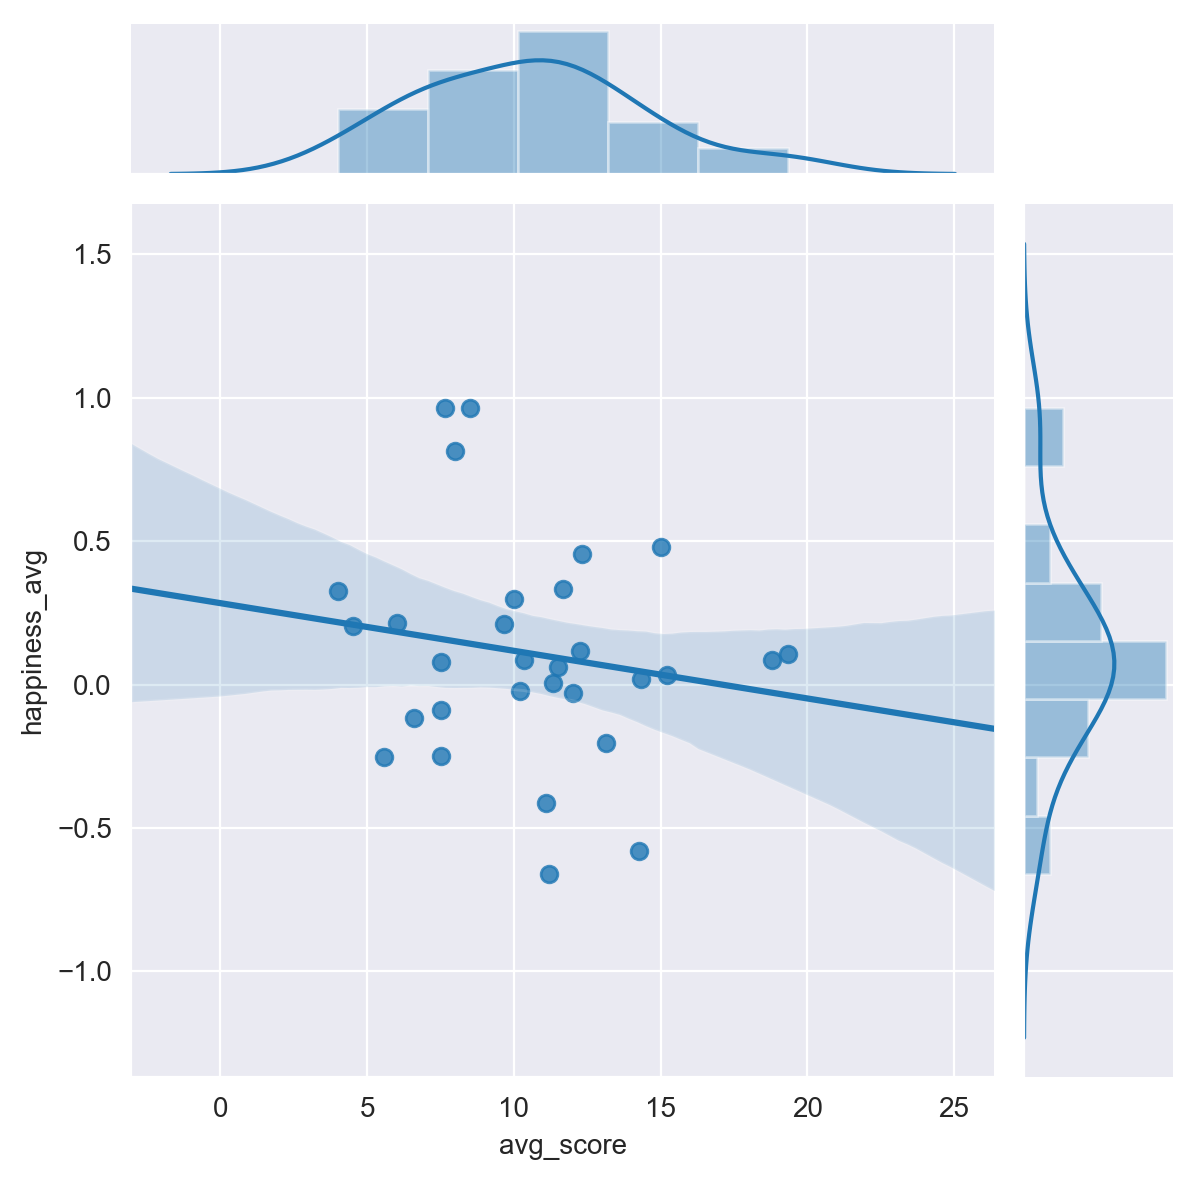

In [998]:
sns.jointplot(variant_df.avg_score, variant_df.happiness_avg, kind='regg')